In [2]:
import pandas as pd

file_path2='/Users/kkkg0829/Desktop/project/data set/B0005_with_lowess_features.csv'

df=pd.read_csv(file_path2)

In [3]:
import numpy as np
import plotly.express as px
import plotly.io as pio
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
pio.renderers.default = "notebook_connected"

# 1. 사용할 feature 선택
features1 = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

X = df[features1]

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lof = LocalOutlierFactor(
    n_neighbors=30,
    contamination='auto' # 예상 이상치 비율
)

y_pred = lof.fit_predict(X_scaled)
lof_scores = -lof.negative_outlier_factor_

# threshold 설정 (직접 계산한 값 사용)
threshold = 1.676333654209548

df['lof_scores'] = lof_scores              # 실제 LOF score
df['lof_anomaly'] = (df['lof_scores'] > threshold).astype(int)  # 0/1로 변환

print("LOF 이상치:", df['lof_anomaly'].sum())


LOF 이상치: 638


기존 LOF baseline 모델(contamination=0.05)에서 결정된 threshold(1.6)를

고정된 기준으로 삼아,

LOWESS trend/residual 기반 features를 추가했을 때

동일 기준에서 anomaly detection sensitivity가 증가하는지 비교하였다.

결과적으로 638개의 anomaly window가 탐지되어, 파생변수 추가가 단발성 스파이크 및 국소 패턴 이상 탐지에 효과적임을 확인했다.

In [4]:
import plotly.express as px

cycle_df = df.groupby('cycle_idx')['lof_scores'].mean().reset_index()

fig = px.line(
    cycle_df,
    x='cycle_idx',
    y='lof_scores',      
    title='Average LOF Score per Cycle',
    markers=True
)
fig.show()

In [5]:
cycle_anom = df.groupby('cycle_idx')['lof_anomaly'].sum().reset_index()

fig = px.bar(
    cycle_anom,
    x='cycle_idx',
    y='lof_anomaly',
    title='Number of Anomalies per Cycle'
)
fig.show()


In [6]:
cycle_peak = df.groupby('cycle_idx')['lof_scores'].max().reset_index()
cycle_peak['is_anomaly'] = (cycle_peak['lof_scores'] > threshold).astype(int)

fig = px.line(
    cycle_peak,
    x='cycle_idx',
    y='lof_scores',
    title='Peak LOF Score per Cycle',
    markers=True
)
fig.show()

In [7]:
anom_cycles=df[df['lof_anomaly']==1]['cycle_idx'].unique()
print('Anomalic cycles:', anom_cycles)
print('number of Anomalic cycles:', len(anom_cycles))

Anomalic cycles: [  4   6   8  10  14  16  18  20  25  27  35  37  46  54  62  70  82  86
  90  94  98 102 106 110 114 118 122 130 134 136 144 148 150 154 158 166
 170 174 182 186 190 194 198 202 206 210 214 216 220 224 228 232 236 240
 244 248 252 256 260 264 270 274 278 286 290 294 298 302 306 316 320 324
 328 332 336 348 364 367 371 383 391 395 399 411 431 437 441 445 457 465
 469 473 477 481 483 485 493 509 517 525 529 533 537 541 545 548 556 564
 576 580 584 588 592 596 600 604 608 612 614]
number of Anomalic cycles: 119


In [8]:
cycle_anomaly_ratio = df.groupby('cycle_idx')['lof_anomaly'].mean().reset_index() # 이상 윈도우비율
# cycle_anomaly_ratio
cycle_anomaly_ratio['is_cycle_anomaly'] = (cycle_anomaly_ratio['lof_anomaly'] > 0.1).astype(int)
print("이상치윈도우가 0.1 초과인 싸이클 수:", cycle_anomaly_ratio['is_cycle_anomaly'].sum())
print("이상치윈도우가 0.1 초과인 싸이클 번호:", cycle_anomaly_ratio[cycle_anomaly_ratio['is_cycle_anomaly']==1]['cycle_idx'].values)

이상치윈도우가 0.1 초과인 싸이클 수: 4
이상치윈도우가 0.1 초과인 싸이클 번호: [134 150 154 614]


윈도우 기반 LOF는 단발성 이상이나 noise에 매우 민감하게 반응하여 fine-grain(아주 작고 세밀한 단위를 봄) 이상 패턴을 탐지한다.”

“그러나 cycle-level health anomaly를 판단하기 위해서는 이상 window 비율 기반의 2차 판단이 필요하다.”

“603개 window anomaly 중 cycle anomaly threshold(10%)를 통과한 cycle은 단 4개였다.”

“이는 변동성 신호는 곳곳에서 포착되지만 실제 열화(cycle-level structural degradation)는 일부 cycle에서만 나타난다는 것을 의미한다.

In [9]:
cycle_anomaly_ratio = df.groupby('cycle_idx')['lof_anomaly'].mean().reset_index() # 이상 윈도우비율
# cycle_anomaly_ratio
cycle_anomaly_ratio['is_cycle_anomaly'] = (cycle_anomaly_ratio['lof_anomaly'] > 0.05).astype(int)
print("이상치윈도우가 0.05 초과인 싸이클 수:", cycle_anomaly_ratio['is_cycle_anomaly'].sum())
print("이상치윈도우가 0.05 초과인 싸이클 번호:", cycle_anomaly_ratio[cycle_anomaly_ratio['is_cycle_anomaly']==1]['cycle_idx'].values)

이상치윈도우가 0.05 초과인 싸이클 수: 4
이상치윈도우가 0.05 초과인 싸이클 번호: [134 150 154 614]


In [10]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=300,
    contamination=0.005,
    random_state=42
)
y_if = iforest.fit_predict(X_scaled)   # 1 = normal, -1 = anomaly
df['if_anomaly'] = (y_if == -1).astype(int)

both = (df['lof_anomaly'] == 1) & (df['if_anomaly'] == 1)
print("LOF 이상치:", df['lof_anomaly'].sum())
print("IF 이상치 :", df['if_anomaly'].sum())
print("둘 다 이상 :", both.sum())


LOF 이상치: 638
IF 이상치 : 252
둘 다 이상 : 45


In [11]:
both_mask = (df['lof_anomaly'] == 1) & (df['if_anomaly'] == 1)
both_cycles = (
    df.loc[both_mask, 'cycle_idx']   # 공통 이상인 윈도우들의 cycle 번호
      .dropna()
      .unique()
)

both_cycles = np.sort(both_cycles)   # 정렬 (선택)
print("공통 이상 cycle 인덱스들:", both_cycles)
print("공통 이상 cycle 개수:", len(both_cycles))

공통 이상 cycle 인덱스들: [ 86  90  94  98 102 110 114 122 144 170 202 206 214 224 240 244 248 252
 260 264 274 278 290 324 367 445 465 469 477 485 529]
공통 이상 cycle 개수: 31


In [12]:
# 히스토그램으로 점수 분포 겹쳐서 그리기
import plotly.express as px

fig_score = px.histogram(df, x='lof_scores', color='lof_anomaly',
                         nbins=100,
                         title='LOF Score 분포: 정상(0) vs 이상(1)',
                         labels={'lof_anomaly': 'Label (0:Normal, 1:Anomaly)'},
                         opacity=0.7,
                         log_y=True) # 데이터 개수 차이가 크므로 y축을 로그 스케일로
fig_score.show()

In [13]:
# Boxplot으로 잔차 분포 비교
fig_res = px.box(df, x='lof_anomaly', y='Voltage_measured_residual',
                 color='lof_anomaly',
                 title='정상 vs 이상: 전압 잔차(Residual) 크기 비교',
                 points='outliers') # 모든 점을 찍지 않고 이상치만 점으로 표시
fig_res.show()

In [14]:
# Cycle별 이상치 빈도 (Aging Correlation)
cycle_anomaly_counts = df[df['lof_anomaly'] == 1]['cycle_idx'].value_counts().sort_index()

fig_cycle = px.bar(
    x=cycle_anomaly_counts.index,
    y=cycle_anomaly_counts.values,
    title='<b>[Temporal Trend] Anomaly Frequency per Cycle</b>',
    labels={'x': 'Cycle Index', 'y': 'Anomaly Count'},
    color=cycle_anomaly_counts.values,
    color_continuous_scale='Viridis'
)

fig_cycle.update_layout(xaxis_title="Battery Aging (Cycle)", yaxis_title="Number of Anomalies")
fig_cycle.show()

In [15]:
import plotly.graph_objects as go

# 134번 사이클(이상치 폭발) vs 86번 사이클(정상) 비교
# 1. 비교 대상 자동 선택
# (1) 이상치 사이클: 사용자가 지정한 134번
bad_cycle_idx = 134

# (2) 정상 사이클: 데이터 개수가 가장 많은(끊김 없는) 정상 사이클 하나를 자동 선택
# 정상 데이터(Label 0) 중에서 사이클별 데이터 개수를 센다
normal_counts = df[df['lof_anomaly'] == 0]['cycle_idx'].value_counts()
# 가장 데이터가 풍부한 사이클 번호를 가져옵니다.
normal_cycle_idx = normal_counts.index[0]

print(f"=== 비교 대상 선정 ===")
print(f"이상치 사이클: {bad_cycle_idx}번")
print(f"정상 사이클 (자동선택): {normal_cycle_idx}번")

# 2. 데이터 추출
cycle_bad = df[df['cycle_idx'] == bad_cycle_idx]
cycle_normal = df[df['cycle_idx'] == normal_cycle_idx]

# 데이터 개수 확인 (혹시 0개인지 체크)
print(f" - 이상치 데이터 개수: {len(cycle_bad)}개")
print(f" - 정상 데이터 개수: {len(cycle_normal)}개")

# 3. 그래프 그리기
if len(cycle_normal) > 0 and len(cycle_bad) > 0:
    fig_compare = go.Figure()

    # 정상 사이클 (파란색 실선)
    fig_compare.add_trace(go.Scatter(
        x=np.arange(len(cycle_normal)),
        y=cycle_normal['Voltage_measured'],
        mode='lines',
        name=f'Normal Cycle ({normal_cycle_idx})',
        line=dict(color='blue', width=2),
        opacity=0.7
    ))

    # 이상치 사이클 (빨간색 점선)
    fig_compare.add_trace(go.Scatter(
        x=np.arange(len(cycle_bad)),
        y=cycle_bad['Voltage_measured'],
        mode='lines',
        name=f'Anomaly Cycle ({bad_cycle_idx})',
        line=dict(color='red', width=3, dash='dot') # 두께를 키움
    ))

    fig_compare.update_layout(
        title=f'<b>[Comparison] Normal vs Anomaly (Cycle {normal_cycle_idx} vs {bad_cycle_idx})</b>',
        xaxis_title='Time Step (Sequence)',
        yaxis_title='Voltage (V)',
        template='plotly_white',
        hovermode="x unified"
    )

    fig_compare.show()
else:
    print("오류: 선택된 사이클에 데이터가 없습니다.")

=== 비교 대상 선정 ===
이상치 사이클: 134번
정상 사이클 (자동선택): 86번
 - 이상치 데이터 개수: 179개
 - 정상 데이터 개수: 371개


In [16]:
# 누적 이상치 그래프 (Cumulative Anomaly Count)
# 시간이 지날수록 이상치가 얼마나 '쌓이는가'를 봅니다.

# 사이클별 이상치 개수 집계 (없는 사이클은 0으로 채움)
all_cycles = pd.DataFrame({'cycle_idx': df['cycle_idx'].unique()})
anomaly_counts = df[df['lof_anomaly'] == 1]['cycle_idx'].value_counts().reset_index()
anomaly_counts.columns = ['cycle_idx', 'count']

# 병합 및 정렬
trend_df = pd.merge(all_cycles, anomaly_counts, on='cycle_idx', how='left').fillna(0)
trend_df = trend_df.sort_values('cycle_idx')

# 누적 합 계산
trend_df['cumulative_count'] = trend_df['count'].cumsum()

# 시각화
fig_trend = px.area(
    trend_df,
    x='cycle_idx',
    y='cumulative_count',
    title='<b>[Cumulative Trend] Total Anomalies Over Time</b>',
    labels={'cumulative_count': 'Accumulated Anomalies', 'cycle_idx': 'Cycle Index'}
)

fig_trend.update_layout(template='plotly_white')
fig_trend.show()

In [17]:
# Feature Contribution (원인 분석)
# 로직: (이상치 그룹의 평균 - 정상 그룹의 평균) / 데이터 전체의 표준편차
# 의미: "이 피처가 정상보다 몇 시그마(Standard Deviation)만큼 벗어나 있는가?"

# 데이터 분리
normal_df = df[df['lof_anomaly'] == 0][features1]
anomaly_df = df[df['lof_anomaly'] == 1][features1]

# 차이 계산 (Z-score 관점의 차이)
diff_series = (anomaly_df.mean() - normal_df.mean()) / df[features1].std()
diff_df = diff_series.reset_index()
diff_df.columns = ['Feature', 'Deviation_Score']
diff_df = diff_df.sort_values(by='Deviation_Score', key=abs, ascending=True) # 절대값 크기순 정렬

# 시각화
fig_reason = px.bar(
    diff_df,
    x='Deviation_Score',
    y='Feature',
    orientation='h',
    title='<b>이상치 원인분석 (Feature Deviation)</b>',
    color='Deviation_Score',
    color_continuous_scale='RdBu_r', # 빨강: 높아서 문제, 파랑: 낮아서 문제
    text_auto='.2f'
)

fig_reason.add_vline(x=0, line_width=2, line_color='black')
fig_reason.update_layout(height=800)
fig_reason.show()

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import plotly.graph_objects as go


# 1. Train/Validation/Test 분할 (6:2:2)

# 고유 cycle 개수
total_cycles = df['cycle_idx'].nunique()

# 6:2:2 split 기준 cycle 개수
train_cycles = int(total_cycles * 0.6)
val_cycles = int(total_cycles * 0.8)  # train + val

# 정렬된 cycle 리스트
cycle_list = sorted(df['cycle_idx'].unique())

# 기준 cycle 번호
train_threshold_cycle = cycle_list[train_cycles - 1]
val_threshold_cycle = cycle_list[val_cycles - 1]

print(f"총 Cycle 수: {total_cycles}")
print(f"Train Cycles: 0 ~ {train_threshold_cycle} ({train_cycles}개)")
print(f"Validation Cycles: {train_threshold_cycle+1} ~ {val_threshold_cycle} ({val_cycles - train_cycles}개)")
print(f"Test Cycles: {val_threshold_cycle+1} ~ {cycle_list[-1]} ({total_cycles - val_cycles}개)")

# 1. Train / Validation / Test split
train_df = df[df['cycle_idx'] <= train_threshold_cycle].copy()
val_df = df[(df['cycle_idx'] > train_threshold_cycle) & (df['cycle_idx'] <= val_threshold_cycle)].copy()
test_df = df[df['cycle_idx'] > val_threshold_cycle].copy()

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


# 2. Feature 준비

features1 = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

X_train = train_df[features1]
X_val = val_df[features1]
X_test = test_df[features1]


# 3. Scaler: Train만으로 학습

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n Scaler 학습 완료 (Train 기준)")


# 4. LOF: Train만으로 학습

lof = LocalOutlierFactor(
    n_neighbors=30,
    contamination='auto',
    novelty=True
)

lof.fit(X_train_scaled)

print("LOF 모델 학습 완료 (Train 기준)")


# 5. 점수 계산 (Train/Validation/Test)

train_scores = -lof.negative_outlier_factor_
val_scores = -lof.score_samples(X_val_scaled)
test_scores = -lof.score_samples(X_test_scaled)

print(f"\n LOF 점수 범위:")
print(f"   Train: {train_scores.min():.4f} ~ {train_scores.max():.4f}")
print(f"   Validation: {val_scores.min():.4f} ~ {val_scores.max():.4f}")
print(f"   Test: {test_scores.min():.4f} ~ {test_scores.max():.4f}")


# 6. Validation으로 Quantile 기반 Threshold 찾기

# 여러 quantile 시도
quantiles = [0.99, 0.995, 0.999]

print("\n" + "="*70)
print(" Quantile 기반 Threshold 비교 (Validation 기준)")
print("="*70)

quantile_results = []

for q in quantiles:
    # Threshold 계산
    thr = np.quantile(val_scores, q)
    
    # 각 데이터셋의 이상치 개수
    val_anom = (val_scores >= thr).sum()
    test_anom = (test_scores >= thr).sum()
    
    quantile_results.append({
        'quantile': q,
        'threshold': thr,
        'val_count': val_anom,
        'val_pct': val_anom / len(val_df) * 100,
        'test_count': test_anom,
        'test_pct': test_anom / len(test_df) * 100
    })
    
    print(f"\nQuantile {q:.3f} (상위 {(1-q)*100:.1f}%):")
    print(f"   Threshold: {thr:.4f}")
    print(f"   Validation 이상치개수/비율: {val_anom}개 ({val_anom/len(val_df)*100:.2f}%)")
    print(f"   Test 이상치개수/비율: {test_anom}개 ({test_anom/len(test_df)*100:.2f}%)")





총 Cycle 수: 168
Train Cycles: 0 ~ 352 (100개)
Validation Cycles: 353 ~ 483 (34개)
Test Cycles: 484 ~ 614 (34개)

Train size: 29361
Validation size: 10664
Test size: 10260

 Scaler 학습 완료 (Train 기준)
LOF 모델 학습 완료 (Train 기준)

 LOF 점수 범위:
   Train: 0.9388 ~ 20.5561
   Validation: 0.9384 ~ 4.2310
   Test: 0.9356 ~ 7.6131

 Quantile 기반 Threshold 비교 (Validation 기준)

Quantile 0.990 (상위 1.0%):
   Threshold: 2.3324
   Validation 이상치개수/비율: 107개 (1.00%)
   Test 이상치개수/비율: 2771개 (27.01%)

Quantile 0.995 (상위 0.5%):
   Threshold: 2.5594
   Validation 이상치개수/비율: 54개 (0.51%)
   Test 이상치개수/비율: 1944개 (18.95%)

Quantile 0.999 (상위 0.1%):
   Threshold: 3.5380
   Validation 이상치개수/비율: 11개 (0.10%)
   Test 이상치개수/비율: 54개 (0.53%)


In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

selected_quantile = 0.999
threshold = np.quantile(val_scores, selected_quantile)


# 1. 점수 & split 정보 붙이기
train_plot = train_df.copy()
val_plot   = val_df.copy()
test_plot  = test_df.copy()

train_plot['score'] = train_scores
val_plot['score']   = val_scores
test_plot['score']  = test_scores

train_plot['split'] = 'train'
val_plot['split']   = 'val'
test_plot['split']  = 'test'

full = pd.concat([train_plot, val_plot, test_plot], ignore_index=True)

# 이상치 여부
full['is_anom'] = full['score'] >= threshold

# 2. cycle 단위 요약 (예: max score, 이상치 비율)
cycle_summary = (
    full.groupby(['split', 'cycle_idx'])
        .agg(
            max_score=('score', 'max'),
            mean_score=('score', 'mean'),
            frac_anom=('is_anom', 'mean')   # 해당 cycle 내 이상치 비율
        )
        .reset_index()
)

# cycle에 하나라도 이상치 있으면 True
cycle_summary['has_anom'] = cycle_summary['frac_anom'] > 0
cycle_summary['has_anom'] = cycle_summary['has_anom'].map({True: 'anomaly cycle', False: 'normal cycle'})

# 3. cycle-wise anomaly plot (max score 기준)
fig = px.scatter(
    cycle_summary,
    x='cycle_idx',
    y='max_score',
    color='split',            # train/val/test 구분
    symbol='has_anom',        # 이상 cycle 표시
    hover_data=['frac_anom', 'mean_score'],
    title='Cycle-wise LOF anomaly (max score per cycle)'
)

# threshold 수평선 추가
fig.add_hline(
    y=thr,
    line_dash='dash',
    line_color='red',
    annotation_text=f'threshold={threshold:.4f}',
    annotation_position='top left'
)

fig.update_layout(xaxis_title='cycle_idx', yaxis_title='max LOF score')
fig.show()


In [20]:
import plotly.graph_objects as go

fig_hist = go.Figure()

# Histogram - Validation
fig_hist.add_trace(go.Histogram(
    x=val_scores,
    name="Validation",
    opacity=0.6,
    marker_color='blue',
    nbinsx=50
))

# Histogram - Test
fig_hist.add_trace(go.Histogram(
    x=test_scores,
    name="Test",
    opacity=0.6,
    marker_color='orange',
    nbinsx=50
))

# Threshold 표시
fig_hist.add_vline(
    x=threshold,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Threshold={threshold:.3f}",
)

fig_hist.update_layout(
    title="Histogram: Validation vs Test LOF Scores",
    barmode='overlay',
    xaxis_title="LOF anomaly score",
    yaxis_title="Count"
)

fig_hist.show()


In [21]:
import plotly.figure_factory as ff

fig_kde = ff.create_distplot(
    [val_scores, test_scores], 
    group_labels=["Validation", "Test"],
    show_hist=False,     # 히스토그램 숨김
    show_rug=False       # rug 숨김
)

# Threshold 선 표시
fig_kde.add_vline(
    x=threshold,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Threshold={threshold:.3f}"
)

fig_kde.update_layout(
    title="KDE Density: Validation vs Test LOF Scores",
    xaxis_title="LOF anomaly score",
    yaxis_title="Density"
)

fig_kde.show()

In [22]:
full

Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0              4.191492         -0.004902             24.330034       -0.0006   
1              4.190749         -0.001478             24.325993       -0.0006   
2              3.974871         -2.012528             24.389085       -1.9982   
3              3.951717         -2.013979             24.544752       -1.9982   
4              3.934352         -2.011144             24.731385       -1.9982   
...                 ...               ...                   ...           ...   
50280          3.579262         -0.001569             34.864823        0.0006   
50281          3.581964         -0.003067             34.814770        0.0006   
50282          3.584484         -0.003079             34.676258        0.0006   
50283          3.587336          0.001219             34.565580        0.0006   
50284          3.589937         -0.000583             34.405920        0.0006   

       Voltage_load  cycle_idx  Voltage_measured_smooth  \
0             0.000          2                 4.191492   
1             4.206          2                 4.190749   
2             3.062          2                 3.974871   
3             3.030          2                 3.951717   
4             3.011          2                 3.934352   
...             ...        ...                      ...   
50280         0.000        614                 3.578546   
50281         0.000        614                 3.581578   
50282         0.000        614                 3.584602   
50283         0.000        614                 3.587614   
50284         0.000        614                 3.590615   

       Voltage_measured_residual  Voltage_measured_trend  \
0                       0.000000               -0.000743   
1                       0.000000               -0.108310   
2                       0.000000               -0.119516   
3                       0.000000               -0.020259   
4                       0.000000               -0.015829   
...                          ...                     ...   
50280                   0.000716                0.003035   
50281                   0.000386                0.003028   
50282                  -0.000118                0.003018   
50283                  -0.000278                0.003007   
50284                  -0.000677                0.003001   

       Current_measured_smooth  ...  Current_load_trend  Voltage_load_smooth  \
0                    -2.012707  ...        3.108624e-14                0.000   
1                    -2.012723  ...        3.774758e-15                4.206   
2                    -2.012746  ...       -1.232348e-14                3.062   
3                    -2.012799  ...        0.000000e+00                3.030   
4                    -2.012904  ...        1.110223e-15                3.011   
...                        ...  ...                 ...                  ...   
50280                -0.000686  ...       -7.047314e-19                0.000   
50281                -0.000689  ...       -7.047314e-19                0.000   
50282                -0.000717  ...       -1.192622e-18                0.000   
50283                -0.000761  ...       -5.149960e-18                0.000   
50284                -0.000810  ...       -1.160096e-17                0.000   

       Voltage_load_residual  Voltage_load_trend  lof_scores  lof_anomaly  \
0                        0.0              4.2060    0.989095            0   
1                        0.0              1.5310    1.000591            0   
2                        0.0             -0.5880    1.025896            0   
3                        0.0             -0.0255    1.087122            0   
4                        0.0             -0.0195    1.057250            0   
...                      ...                 ...         ...          ...   
50280                    0.0              0.0000    5.057295            1   
50281                    0.

# permutation importance

In [23]:
from sklearn.preprocessing import StandardScaler  
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
import pandas as pd

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

X = full[features]  
y = full['is_anom'].astype(int)

scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')  # 이상치가 적으므로 class_weight로 가중치 조절
rf_model.fit(X_scaled, y)

perm_result = permutation_importance(
    rf_model,
    X_scaled,
    y,
    n_repeats=10,
    random_state=42,
    scoring='f1'  # F1은 불균형 데이터에서 더 안정적
)
				
# importance_df 결과 정리
importance_df = pd.DataFrame({  
    'feature': features,
    'importance': perm_result.importances_mean,  
    'std': perm_result.importances_std  
}).sort_values('importance', ascending=False)
				
print("\n=== Permutation Importance ===")
print(importance_df.head)

# importance_df 시각화

import plotly.express as px

fig = px.bar(
    importance_df,  
    x='importance',  
    y='feature', 
    orientation='h',  
    title='Permutation Importance Result'
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}  # 큰 값이 위로
)

fig.show()


=== Permutation Importance ===
<bound method NDFrame.head of                           feature  importance       std
19             Voltage_load_trend    0.646234  0.043518
11    Temperature_measured_smooth    0.553775  0.020044
7          Voltage_measured_trend    0.551418  0.029505
0                Voltage_measured    0.475207  0.016284
17            Voltage_load_smooth    0.448346  0.018171
13     Temperature_measured_trend    0.445328  0.027292
12  Temperature_measured_residual    0.425997  0.024921
2            Temperature_measured    0.393851  0.027670
5         Voltage_measured_smooth    0.348502  0.020394
14            Current_load_smooth    0.254876  0.026329
4                    Voltage_load    0.242204  0.013636
1                Current_measured    0.140892  0.019639
18          Voltage_load_residual    0.140200  0.013656
6       Voltage_measured_residual    0.097769  0.010615
3                    Current_load    0.095849  0.009222
9       Current_measured_residual    0.091

# Tree Shap


전체 데이터: 50285개
이상치: 127개 (0.25%)

 RandomForest Surrogate 학습 중...
 학습 완료 (정확도: 1.0000)

총 이상치: 127개
SHAP 분석 샘플: 20개 선택

 Tree SHAP Explainer 생성 중...
 SHAP 값 계산 중...
 SHAP 값 계산 완료
   shap_values type: <class 'numpy.ndarray'>
   shap_values shape: (20, 20, 2)

 expected_value 확인:
   type: <class 'numpy.ndarray'>
   length: 2
   values: [0.50624329 0.49375671]
   base_value: 0.4937567104654679

 shap_values는 3차원 배열
   Class 1 shape: (20, 20)

 [1/4] Summary Plot (Bar)


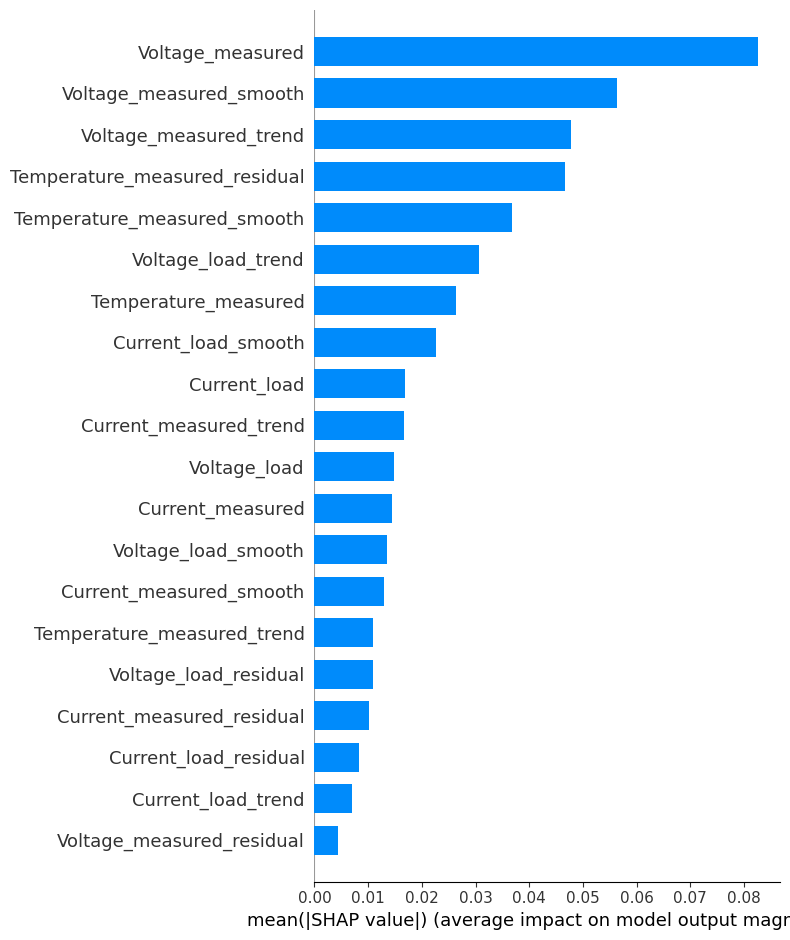


 [2/4] Beeswarm Plot


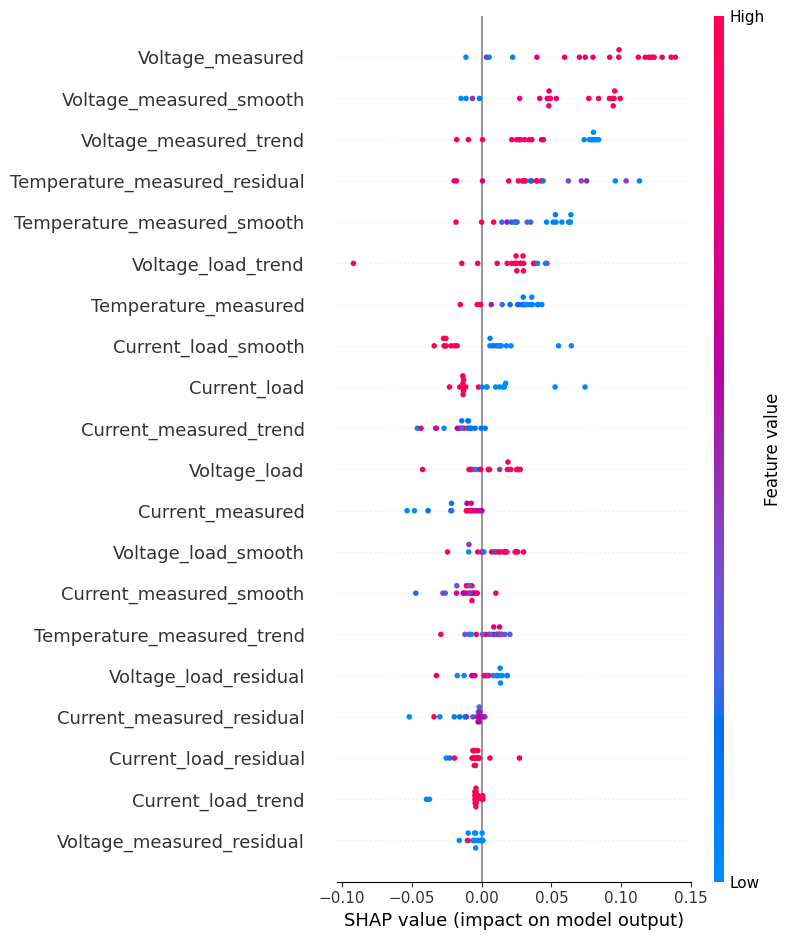


 [3/4] Waterfall Plot

🔍 Anomaly 1/20
   Index: 396
   LOF Score: 5.8917


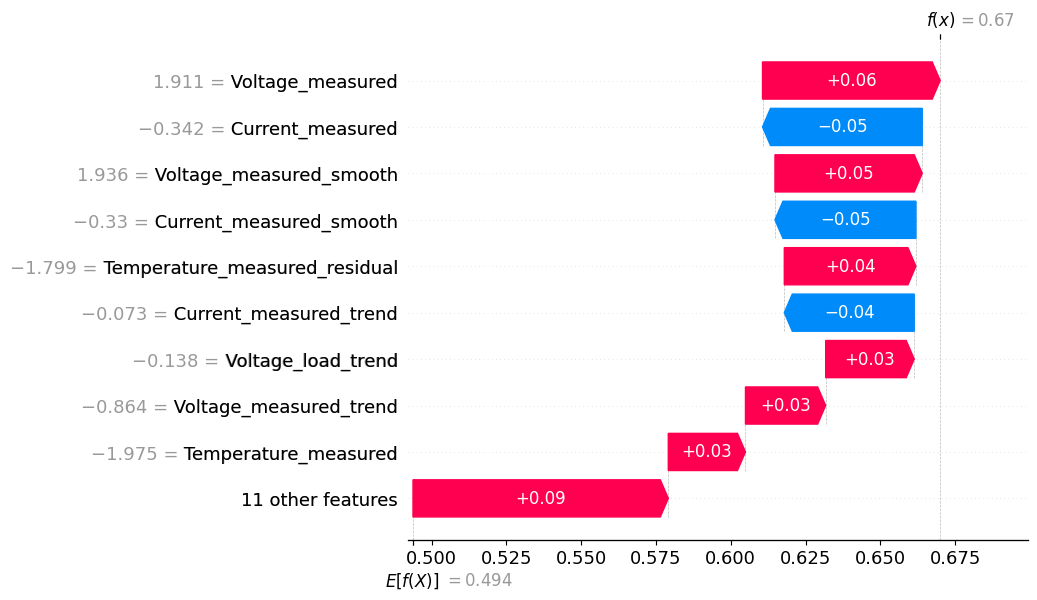


🔍 Anomaly 2/20
   Index: 397
   LOF Score: 4.7088


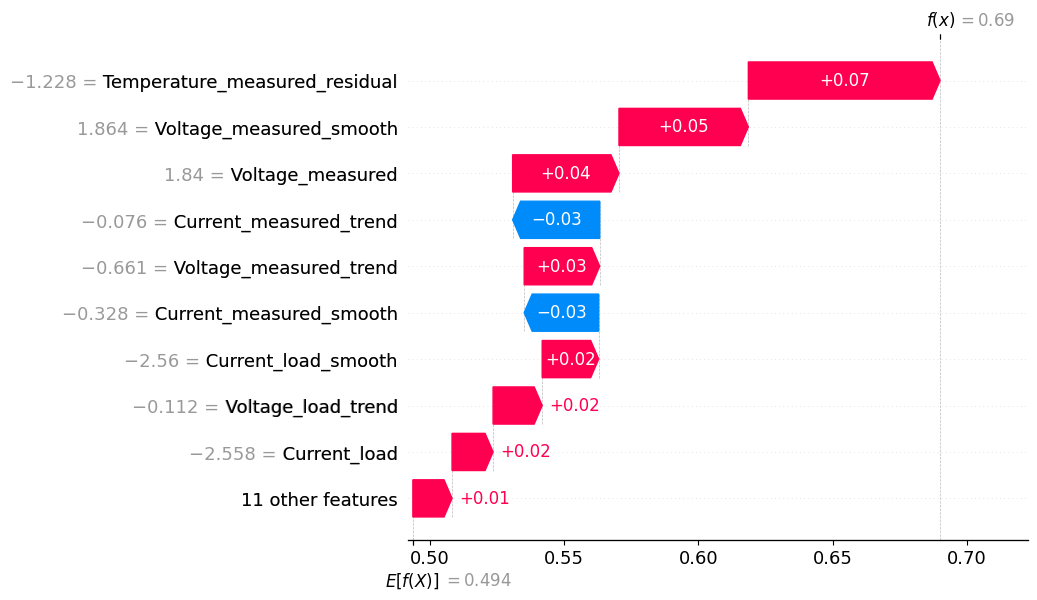


🔍 Anomaly 3/20
   Index: 591
   LOF Score: 6.1262


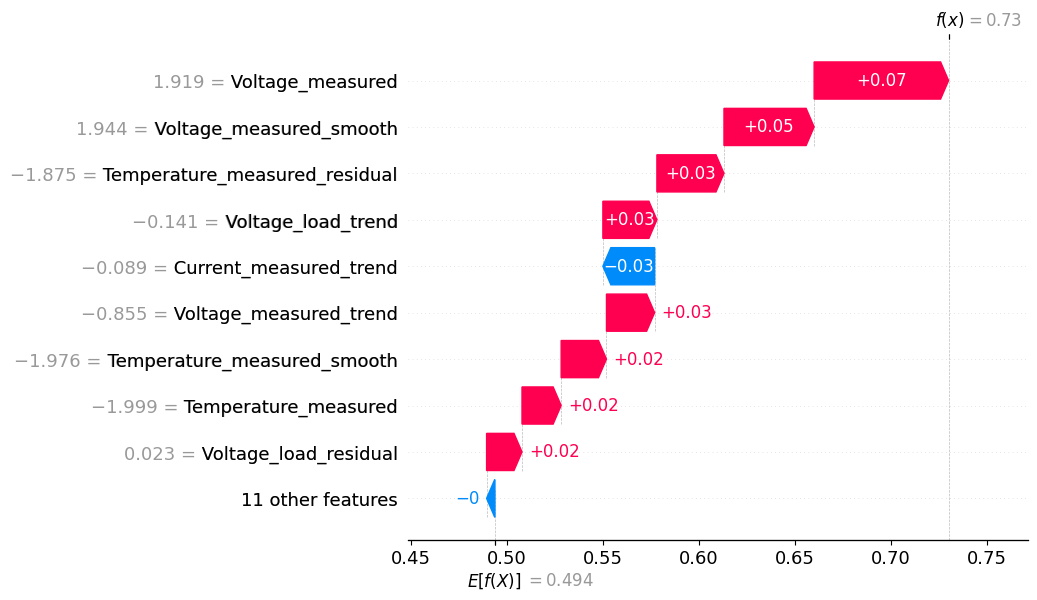


🔍 Anomaly 4/20
   Index: 592
   LOF Score: 4.9214


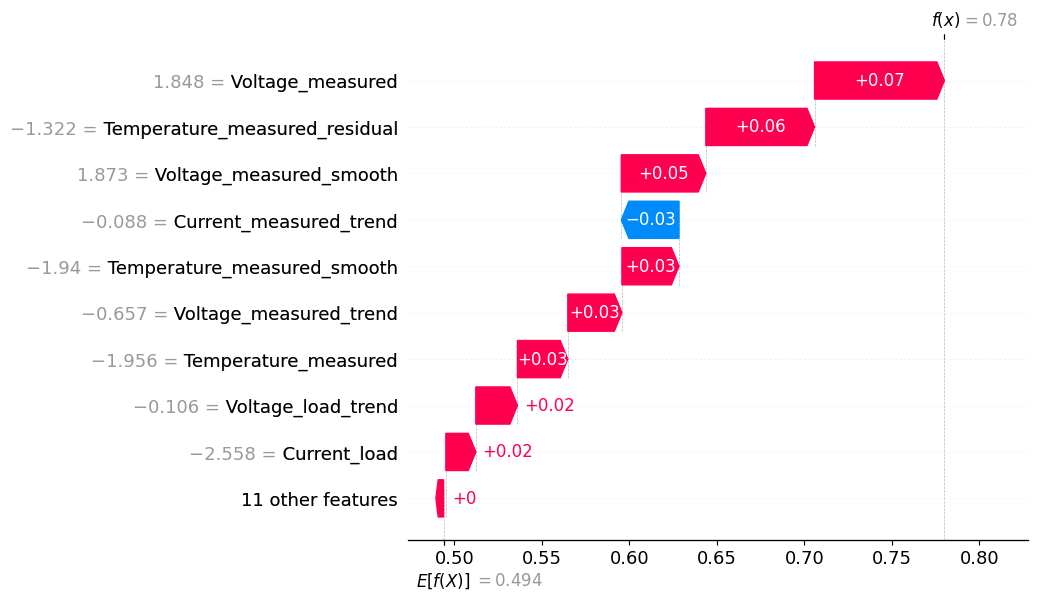


🔍 Anomaly 5/20
   Index: 784
   LOF Score: 12.7886


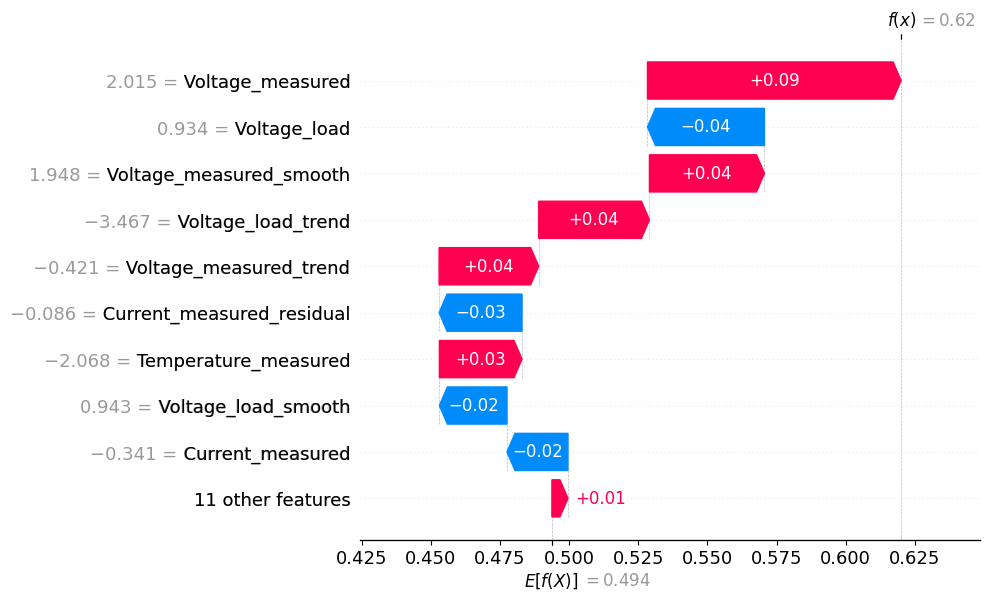


 [4/4] Force Plot

Force Plot 1


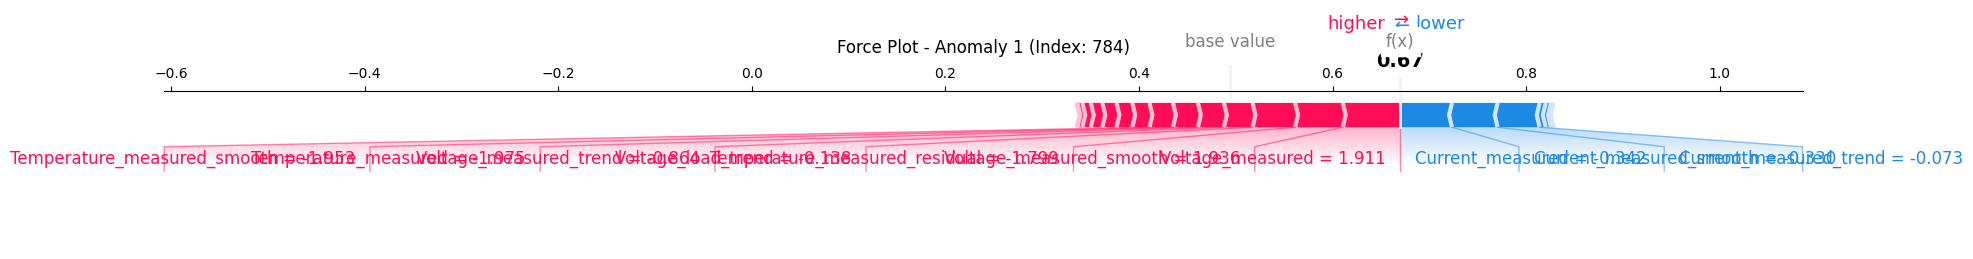


Force Plot 2


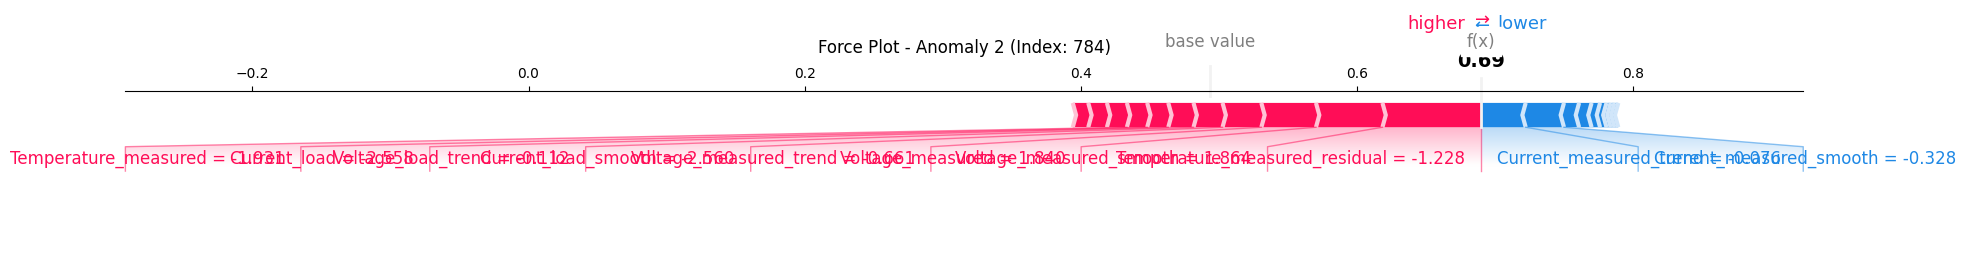


Force Plot 3


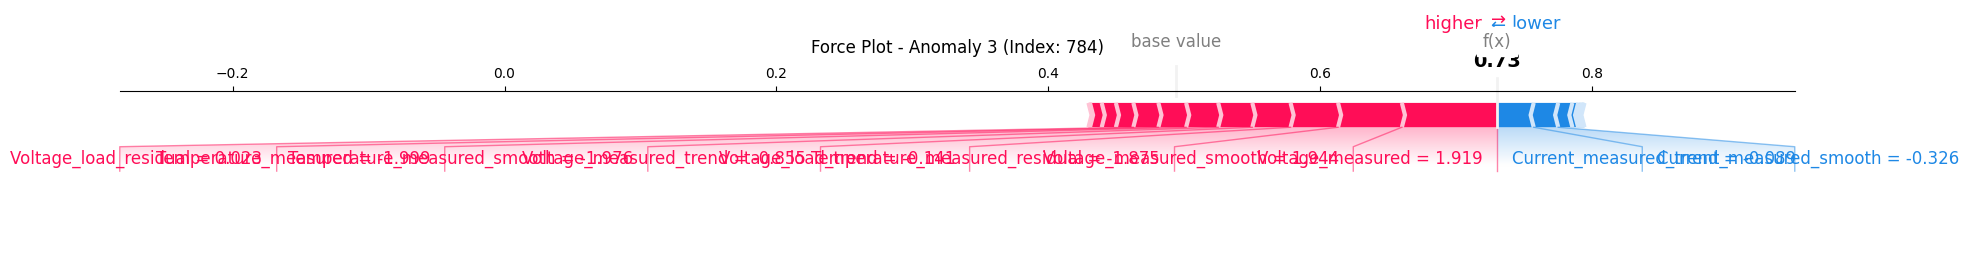


 SHAP Analysis 완료!

 Feature 중요도 요약
                      Feature  Mean |SHAP|  Rank
             Voltage_measured     0.082589     1
      Voltage_measured_smooth     0.056320     2
       Voltage_measured_trend     0.047724     3
Temperature_measured_residual     0.046610     4
  Temperature_measured_smooth     0.036802     5
           Voltage_load_trend     0.030578     6
         Temperature_measured     0.026334     7
          Current_load_smooth     0.022599     8
                 Current_load     0.016865     9
       Current_measured_trend     0.016659    10
                 Voltage_load     0.014844    11
             Current_measured     0.014461    12
          Voltage_load_smooth     0.013592    13
      Current_measured_smooth     0.012915    14
   Temperature_measured_trend     0.010985    15
        Voltage_load_residual     0.010916    16
    Current_measured_residual     0.010178    17
        Current_load_residual     0.008357    18
           Current_load_trend   

In [24]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# 1. 데이터 준비

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

X = full[features]
y = full['is_anom'].astype(int)

print(f"\n전체 데이터: {len(X)}개")
print(f"이상치: {y.sum()}개 ({y.sum()/len(y)*100:.2f}%)")

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# 2. RandomForest 학습

print("\n RandomForest Surrogate 학습 중...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_scaled_df, y)

train_score = rf_model.score(X_scaled_df, y)
print(f" 학습 완료 (정확도: {train_score:.4f})")


# 3. Anomaly 샘플 선택

anomaly_indices = full[full['is_anom'] == True].index.tolist()
print(f"\n총 이상치: {len(anomaly_indices)}개")

if len(anomaly_indices) <= 10:
    n_samples = len(anomaly_indices)
elif len(anomaly_indices) <= 30:
    n_samples = 10
else:
    n_samples = 20

print(f"SHAP 분석 샘플: {n_samples}개 선택")

sampled_indices = anomaly_indices[:n_samples]
X_anomaly = X_scaled_df.loc[sampled_indices].values


# 4. Tree SHAP

print("\n Tree SHAP Explainer 생성 중...")
explainer = shap.TreeExplainer(rf_model)

print(" SHAP 값 계산 중...")
shap_values = explainer.shap_values(X_anomaly)

print(f" SHAP 값 계산 완료")
print(f"   shap_values type: {type(shap_values)}")
print(f"   shap_values shape: {shap_values.shape if hasattr(shap_values, 'shape') else 'N/A'}")


# 5. expected_value 처리 (핵심!)

# expected_value의 형태 확인
print(f"\n expected_value 확인:")
print(f"   type: {type(explainer.expected_value)}")

if isinstance(explainer.expected_value, (list, np.ndarray)):
    print(f"   length: {len(explainer.expected_value)}")
    print(f"   values: {explainer.expected_value}")
    
    # 리스트나 배열이면 Class 1 (Anomaly) 선택
    if len(explainer.expected_value) > 1:
        base_value = float(explainer.expected_value[1])
    else:
        base_value = float(explainer.expected_value[0])
else:
    # 스칼라면 그대로 사용
    base_value = float(explainer.expected_value)

print(f"   base_value: {base_value}")


# 6. shap_values 처리

# shap_values의 차원 확인
if isinstance(shap_values, list):
    # 리스트: [Class 0, Class 1]
    shap_values_class1 = shap_values[1]
    print(f"\n shap_values는 리스트 (Class별)")
    print(f"   Class 1 shape: {shap_values_class1.shape}")
elif len(shap_values.shape) == 3:
    # 3차원: (n_samples, n_features, n_classes)
    shap_values_class1 = shap_values[:, :, 1]
    print(f"\n shap_values는 3차원 배열")
    print(f"   Class 1 shape: {shap_values_class1.shape}")
else:
    # 2차원: (n_samples, n_features) - 이진분류
    shap_values_class1 = shap_values
    print(f"\n shap_values는 2차원 배열")
    print(f"   shape: {shap_values_class1.shape}")


# 7. 시각화


# 7-1. Summary Plot (Bar)
print("\n" + "="*70)
print(" [1/4] Summary Plot (Bar)")
print("="*70)

shap.summary_plot(
    shap_values_class1,
    X_anomaly,
    plot_type="bar",
    feature_names=features
)

# 7-2. Beeswarm Plot
print("\n" + "="*70)
print(" [2/4] Beeswarm Plot")
print("="*70)

shap.summary_plot(
    shap_values_class1,
    X_anomaly,
    feature_names=features
)

# 7-3. Waterfall Plot (처음 5개)
print("\n" + "="*70)
print(" [3/4] Waterfall Plot")
print("="*70)

n_anomalies = len(X_anomaly)

for i in range(min(5, n_anomalies)):
    idx = sampled_indices[i]
    
    print(f"\n🔍 Anomaly {i+1}/{n_anomalies}")
    print(f"   Index: {idx}")
    print(f"   LOF Score: {full.loc[idx, 'score']:.4f}")

   
    #  base_values를 스칼라로 전달
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_class1[i],
            base_values=base_value,  #  스칼라 값!
            data=X_anomaly[i],
            feature_names=features
        )
    )

# 7-4. Force Plot (처음 3개)
print("\n" + "="*70)
print(" [4/4] Force Plot")
print("="*70)

for i in range(min(3, n_anomalies)):
    print(f"\nForce Plot {i+1}")

    #  소수점 3자리로 제한
     #  Feature 값 반올림 (소수점 3자리)
    data_rounded = np.round(X_anomaly[i], 3)
    
    #  Feature 이름에 값 포함 (소수점 3자리)
    feature_labels = [
        f"{feat} = {val:.3f}" 
        for feat, val in zip(features, data_rounded)
    ]
    
    # Force Plot (matplotlib 버전)
    shap.force_plot(
        base_value,
        shap_values_class1[i],
        feature_names=feature_labels,  
        matplotlib=True,
        show=False
    )
    
    # 제목 추가
    plt.title(f"Force Plot - Anomaly {i+1} (Index: {idx})", fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()


print("\n" + "="*70)
print(" SHAP Analysis 완료!")
print("="*70)


# 8. 통계 요약

print("\n" + "="*70)
print(" Feature 중요도 요약")
print("="*70)

mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

summary_df = pd.DataFrame({
    'Feature': features,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)

summary_df['Rank'] = range(1, len(features) + 1)

print(summary_df.to_string(index=False))

print("\n 해석:")
print("   - Rank 1: 이상치 판단에 가장 중요")
print("   - Waterfall Plot: 개별 anomaly의 원인")
print("   - Beeswarm Plot: feature 값과 SHAP의 관계")

# kernal shap

In [28]:
import shap

def lof_score_predict(X_array):
    """
    X_array: (n_samples, n_features) numpy array or DataFrame.values
    반환: LOF 이상도 점수 (값이 클수록 이상)
    """
    X_scaled=scaler.transform(X_array)
    return -lof.score_samples(X_scaled)

X_train_df = train_df[features1]
X_background = shap.sample(X_train_df, 100, random_state=42)


explainer = shap.KernelExplainer(
    model=lof_score_predict,  
    data=X_background          
)

def run_lof_shap_for_split(
    split_name,         # "Validation" 또는 "Test"
    df_split,           # val_df 또는 test_df
    scores_split,       # val_scores 또는 test_scores
    threshold,          # validation에서 정한 threshold (같은 값 test에 재사용)
    explainer,          # 위에서 만든 KernelExplainer
    feature_cols        # features1
):
    # 원본 건드리지 않도록 copy
    df_split = df_split.copy()
    
    # 1) 점수 & 이상치 플래그
    df_split['lof_score'] = scores_split
    df_split['is_anom'] = df_split['lof_score'] >= threshold

    X_split = df_split[feature_cols]
    X_explain = X_split[df_split['is_anom'] == True]

    n_anomalies = len(X_explain)

    print("\n" + "="*70)
    print(f" [{split_name}] SHAP 분석 시작")
    print(f"  - threshold: {threshold:.4f}")
    print(f"  - 이상 윈도우 수: {n_anomalies}")
    print("="*70)

    if n_anomalies == 0:
        print(f"⚠ [{split_name}] 구간에서 threshold 이상 이상치가 없습니다. threshold를 낮춰보는 것도 방법이에요.")
        return None, None, None

    # 2) SHAP 값 계산
    shap_values = explainer.shap_values(
        X_explain,
        nsamples="auto"   # 필요시 100, 200 등으로 지정 가능
    )

    print("shap_values.shape:", np.array(shap_values).shape)

    # 3) base_value 추출
    base_value = explainer.expected_value
    if isinstance(base_value, (list, np.ndarray)):
        base_value = np.array(base_value).mean()

    # ======================================================
    # [1/4] Summary Plot (Bar)
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [1/4] Summary Plot (Bar)")
    print("="*70)

    shap.summary_plot(
        shap_values,
        X_explain,
        plot_type="bar",
        feature_names=feature_cols
    )

    # ======================================================
    # [2/4] Beeswarm Plot
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [2/4] Beeswarm Plot")
    print("="*70)

    shap.summary_plot(
        shap_values,
        X_explain,
        feature_names=feature_cols
    )

    # ======================================================
    # [3/4] Waterfall Plot (처음 5개)
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [3/4] Waterfall Plot (처음 5개)")
    print("="*70)

    for i in range(min(5, n_anomalies)):
        print(f"\n🔍 [{split_name}] explain {i+1}/{n_anomalies}")
        original_idx = X_explain.index[i]
        print(f"   원본 인덱스: {original_idx}")
        print(f"   LOF Score: {df_split.loc[original_idx, 'lof_score']:.4f}")

        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[i],
                base_values=base_value,
                data=X_explain.iloc[i].values,
                feature_names=feature_cols
            )
        )

    # ======================================================
    # [4/4] Force Plot (처음 3개)
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [4/4] Force Plot (처음 3개)")
    print("="*70)

    for i in range(min(3, n_anomalies)):
        print(f"\nForce Plot {i+1}")
        original_idx = X_explain.index[i]

        data_row = X_explain.iloc[i].values
        data_rounded = np.round(data_row, 3)

        feature_labels = [
            f"{feat} = {val:.3f}"
            for feat, val in zip(feature_cols, data_rounded)
        ]

        shap.force_plot(
            base_value,
            shap_values[i],
            feature_names=feature_labels,
            matplotlib=True,
            show=False
        )

        plt.title(
            f"[{split_name}] Force Plot - explain {i+1} (Index: {original_idx})",
            fontsize=12,
            pad=10
        )
        plt.tight_layout()
        plt.show()

    print("\n" + "="*70)
    print(f" [{split_name}] SHAP Analysis 완료!")
    print("="*70)

    return shap_values, X_explain, base_value


/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [26]:
q = 0.999
threshold = np.quantile(val_scores, q)
print("Validation 기준 threshold:", threshold)

Validation 기준 threshold: 3.537997666777979


# kernal shap validation


 [Validation] SHAP 분석 시작
  - threshold: 3.5380
  - 이상 윈도우 수: 11


  0%|          | 0/11 [00:00<?, ?it/s]

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler 

shap_values.shape: (11, 20)

 [Validation] [1/4] Summary Plot (Bar)


/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

invalid value encountered in matmul



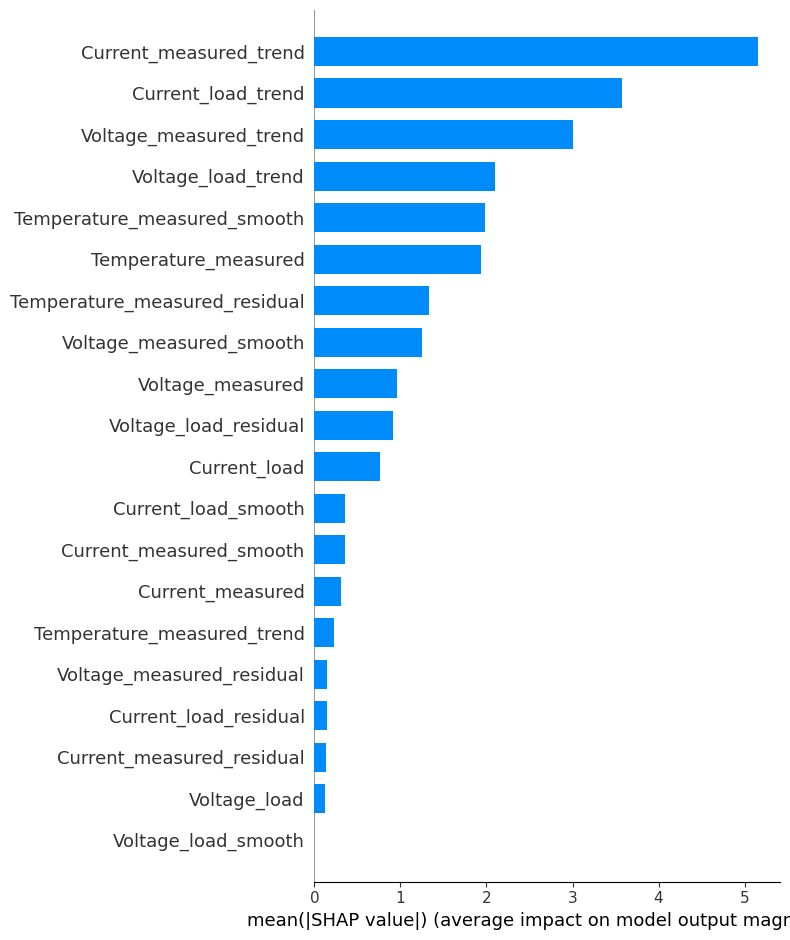


 [Validation] [2/4] Beeswarm Plot


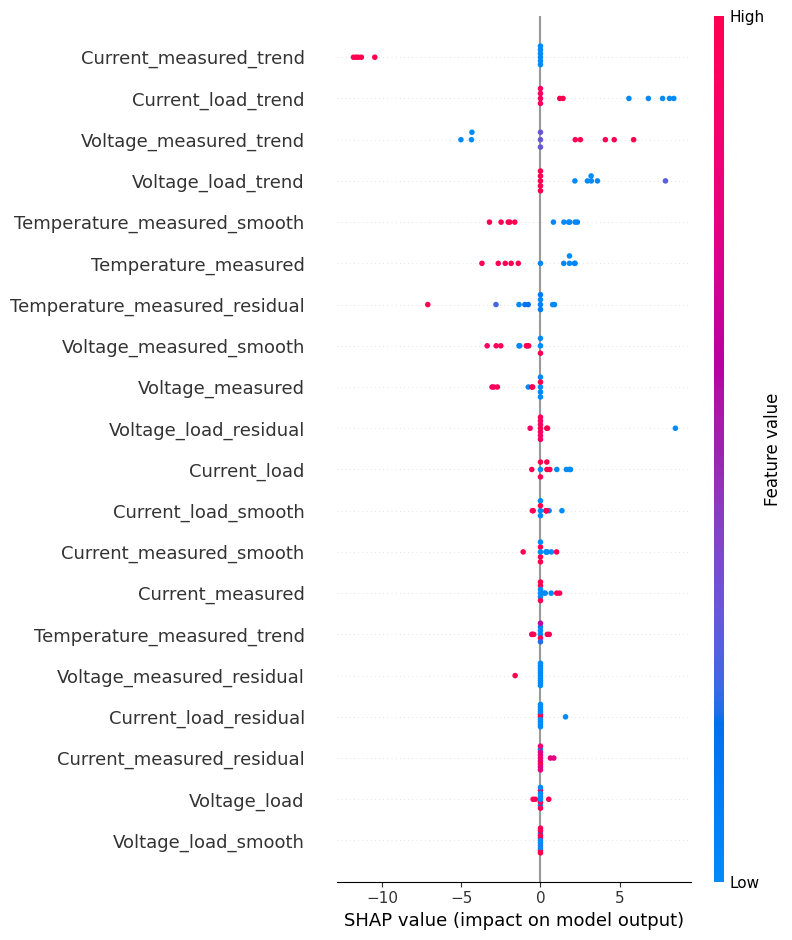


 [Validation] [3/4] Waterfall Plot (처음 5개)

🔍 [Validation] explain 1/11
   원본 인덱스: 30647
   LOF Score: 3.6507


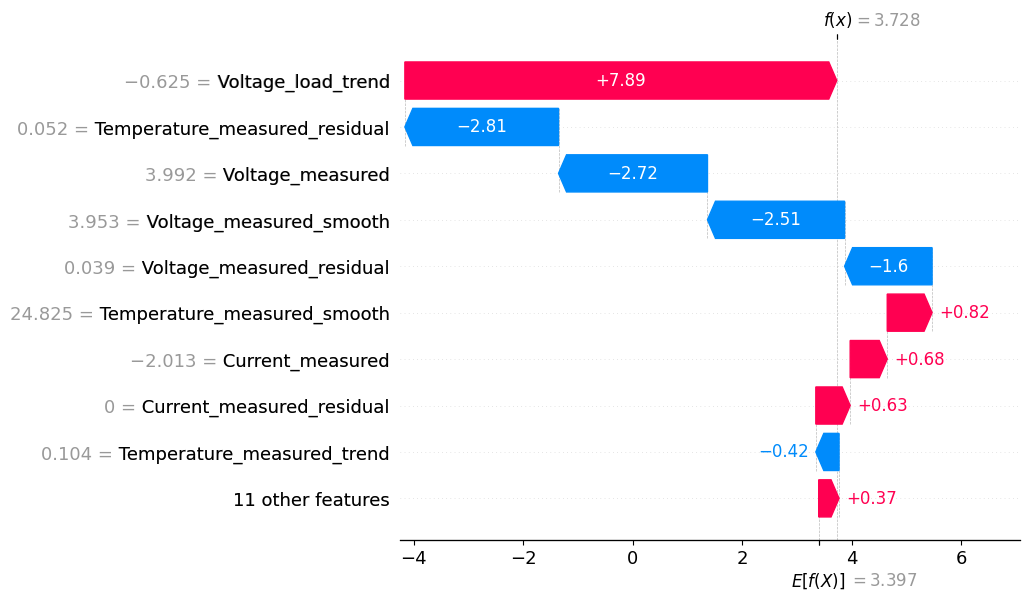


🔍 [Validation] explain 2/11
   원본 인덱스: 31286
   LOF Score: 4.2182


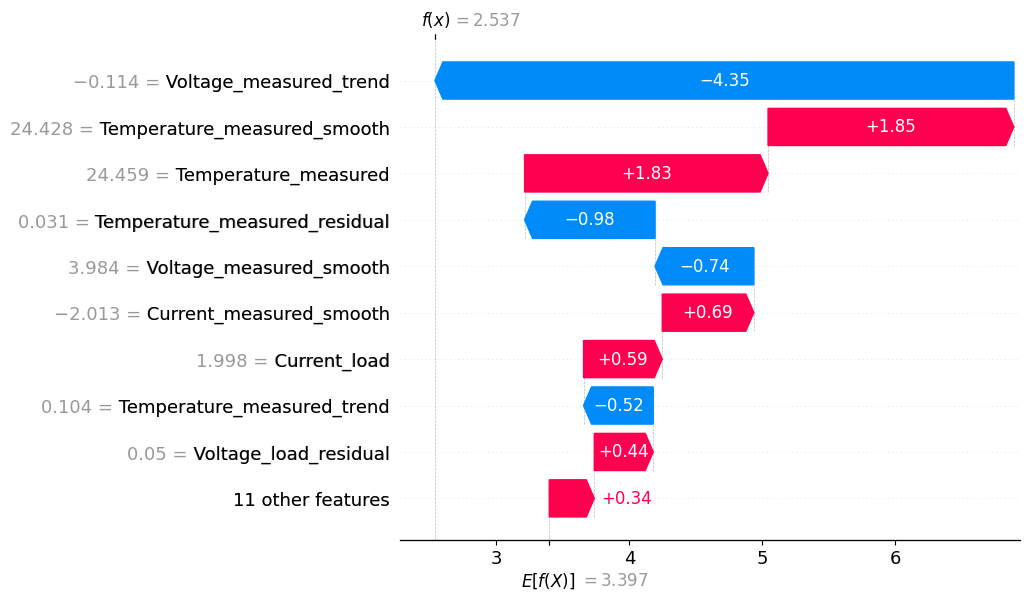


🔍 [Validation] explain 3/11
   원본 인덱스: 31564
   LOF Score: 3.5453


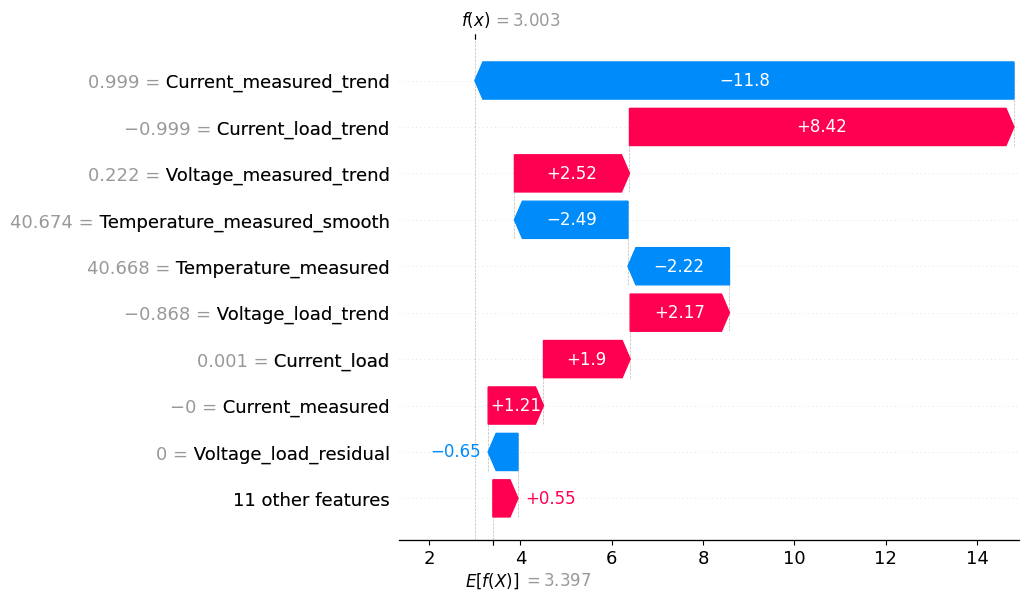


🔍 [Validation] explain 4/11
   원본 인덱스: 32242
   LOF Score: 3.5713


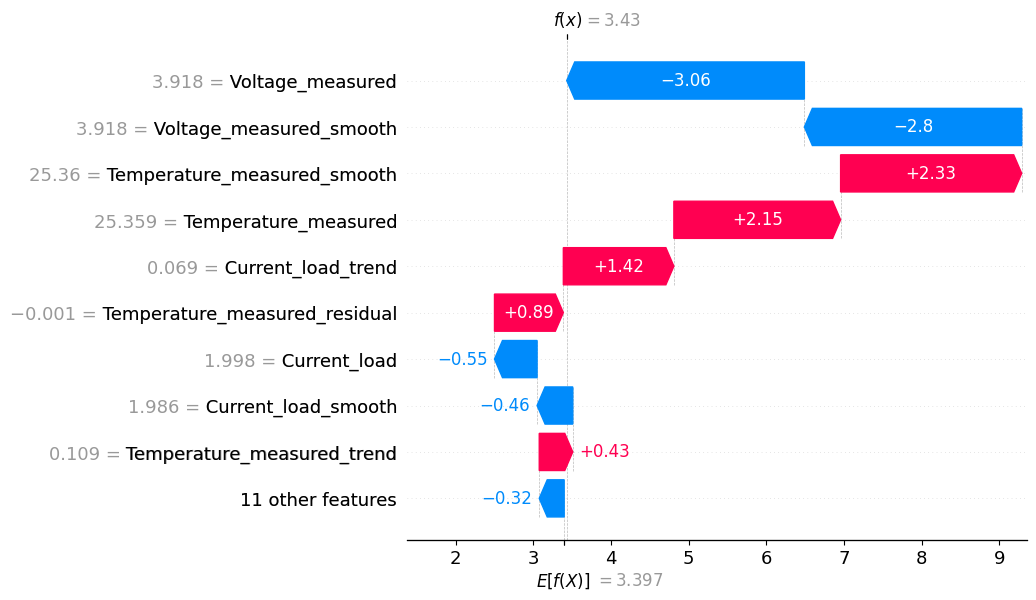


🔍 [Validation] explain 5/11
   원본 인덱스: 32554
   LOF Score: 4.2303


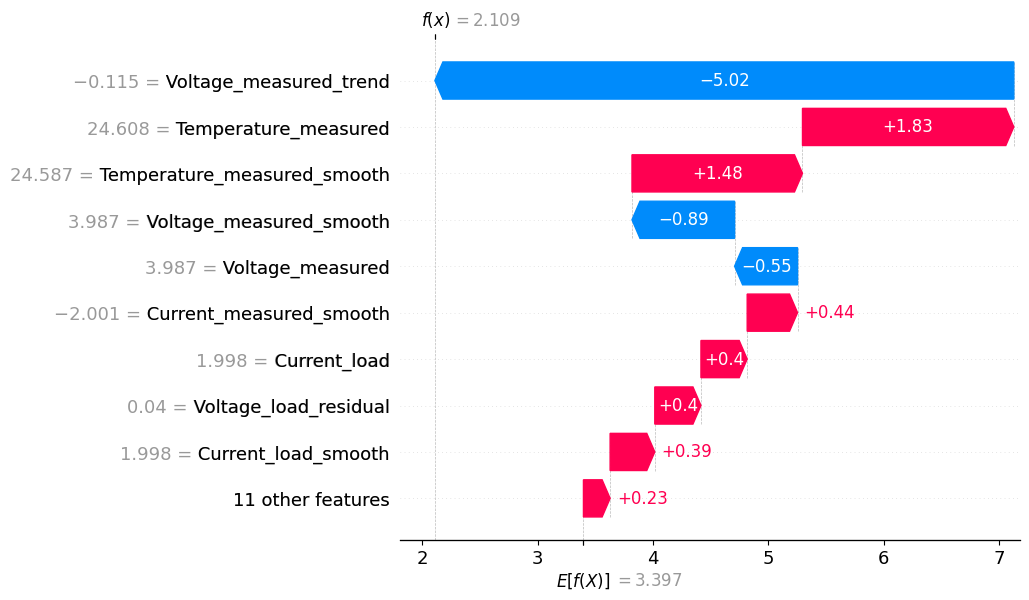


 [Validation] [4/4] Force Plot (처음 3개)

Force Plot 1


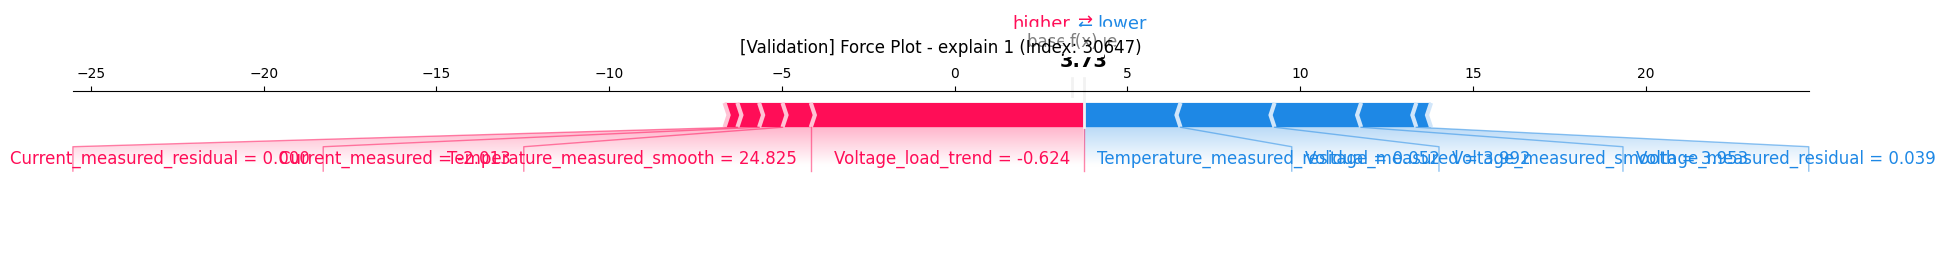


Force Plot 2


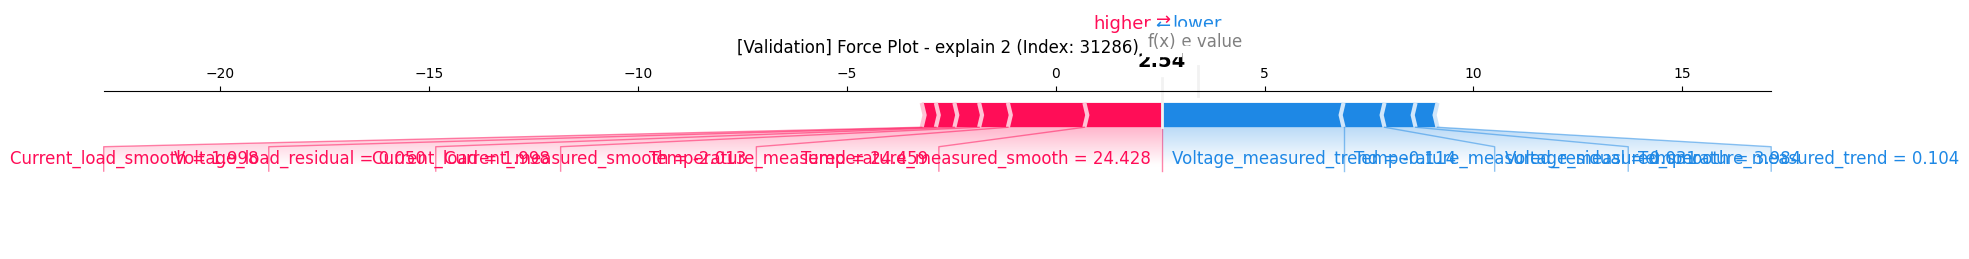


Force Plot 3


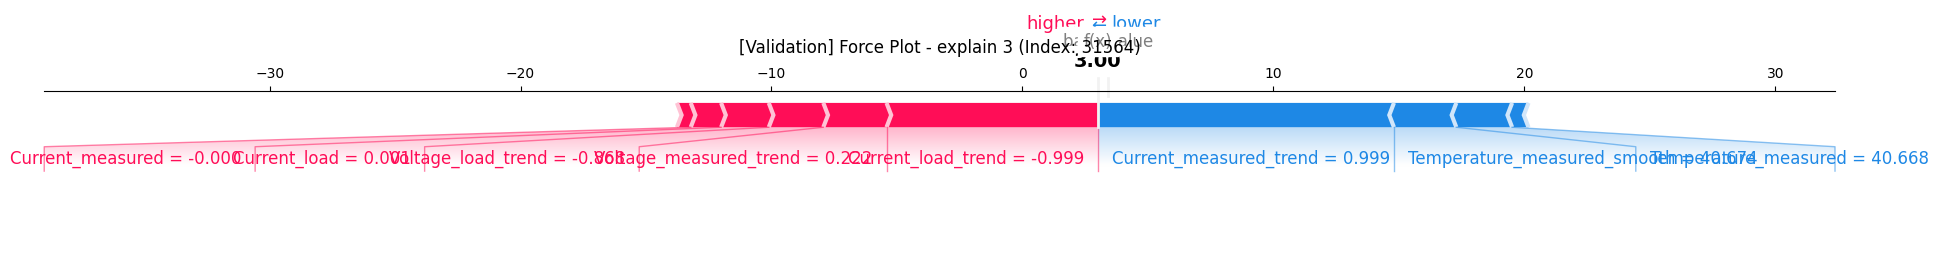


 [Validation] SHAP Analysis 완료!


In [29]:
shap_val, X_val_explain, base_val = run_lof_shap_for_split(
    split_name="Validation",
    df_split=val_df,
    scores_split=val_scores,
    threshold=threshold,
    explainer=explainer,
    feature_cols=features1
)


# kernal shap (Test)


 [Test] SHAP 분석 시작
  - threshold: 3.5380
  - 이상 윈도우 수: 54


  0%|          | 0/54 [00:00<?, ?it/s]

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler 

shap_values.shape: (54, 20)

 [Test] [1/4] Summary Plot (Bar)


/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/NASA_battery/lib/python3.10/site-packages/shap/explainers/_kernel.py:706: RuntimeWarning:

invalid value encountered in matmul



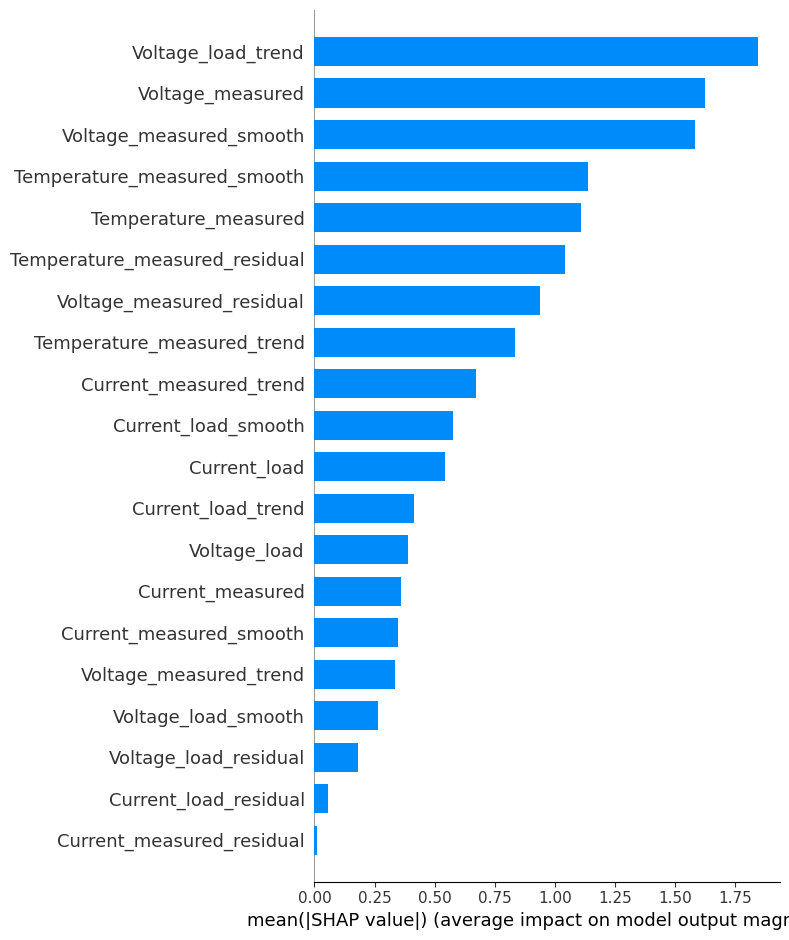


 [Test] [2/4] Beeswarm Plot


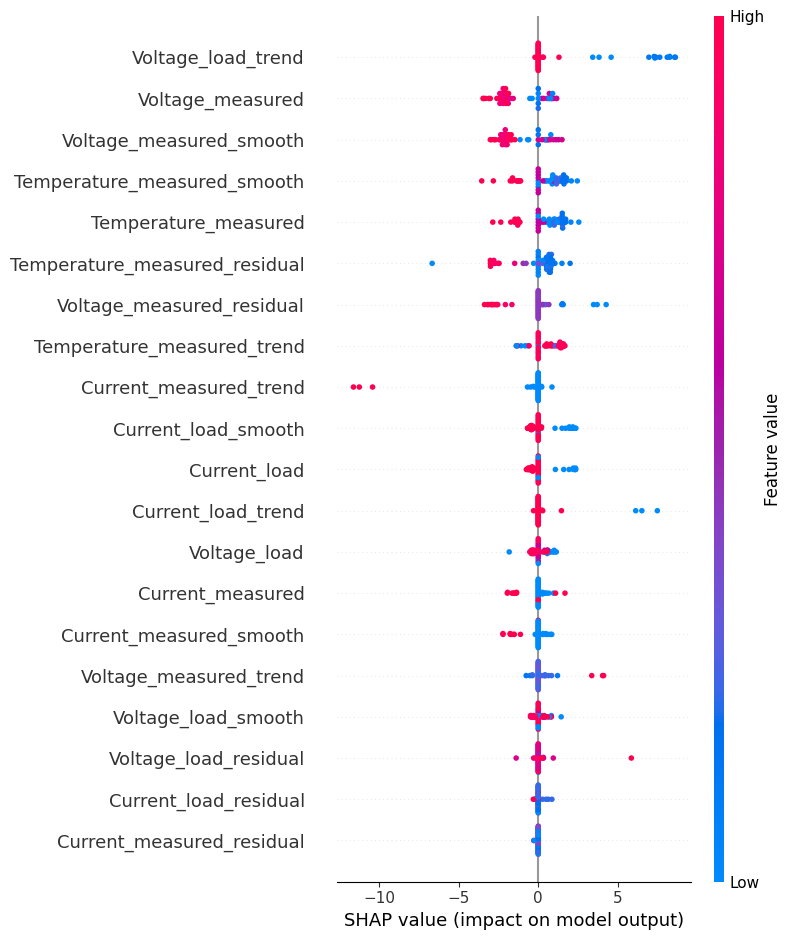


 [Test] [3/4] Waterfall Plot (처음 5개)

🔍 [Test] explain 1/54
   원본 인덱스: 40901
   LOF Score: 3.6130


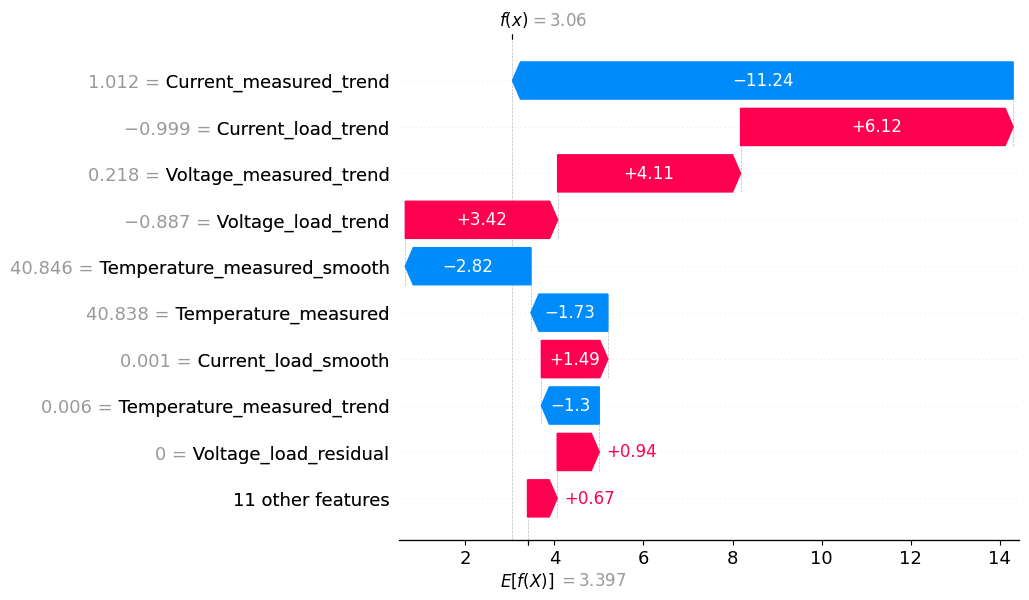


🔍 [Test] explain 2/54
   원본 인덱스: 42729
   LOF Score: 3.8077


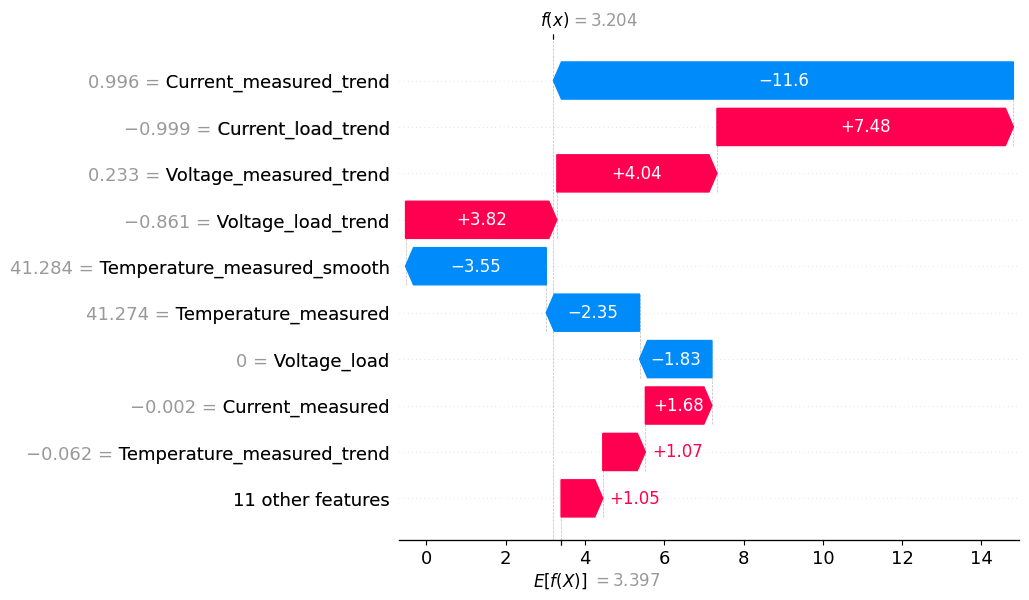


🔍 [Test] explain 3/54
   원본 인덱스: 43329
   LOF Score: 5.8186


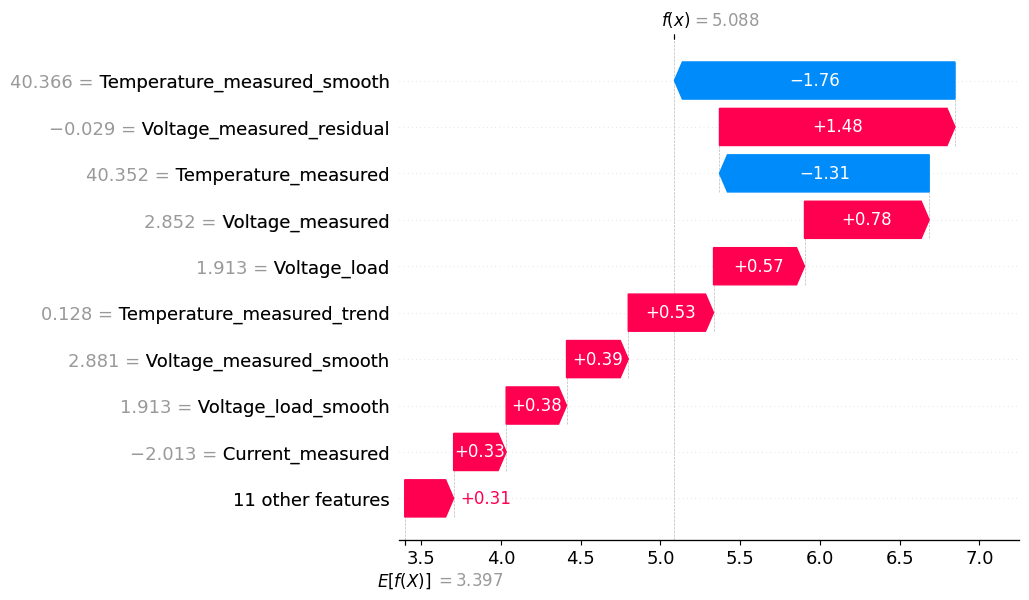


🔍 [Test] explain 4/54
   원본 인덱스: 43330
   LOF Score: 7.2172


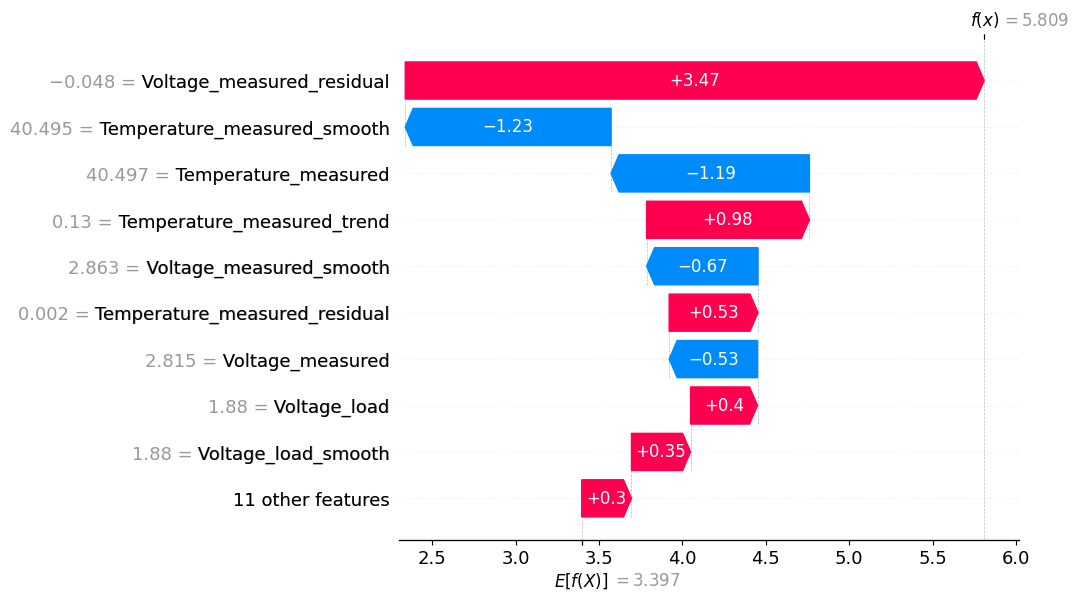


🔍 [Test] explain 5/54
   원본 인덱스: 43383
   LOF Score: 3.7066


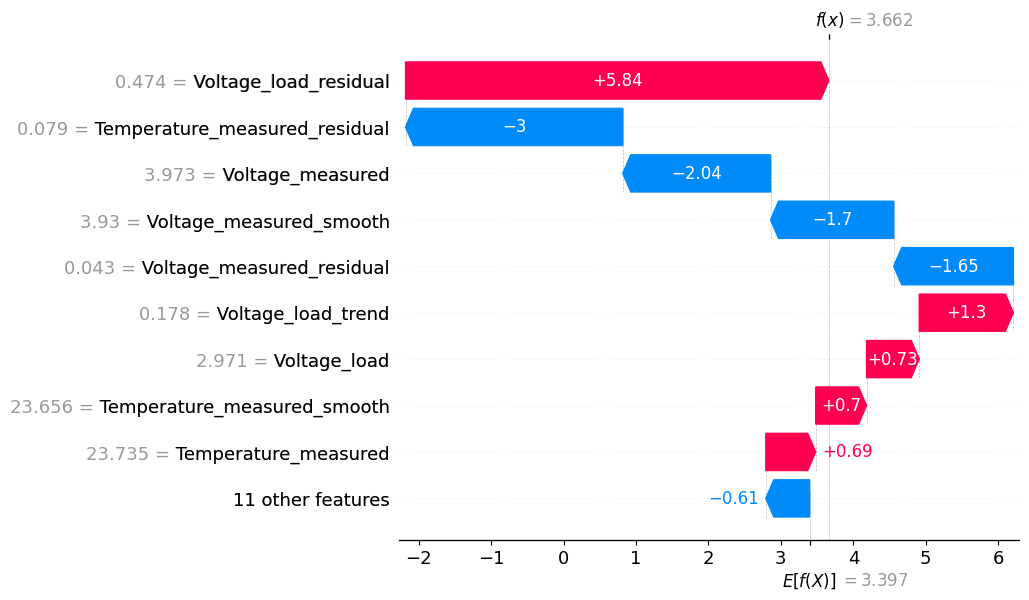


 [Test] [4/4] Force Plot (처음 3개)

Force Plot 1


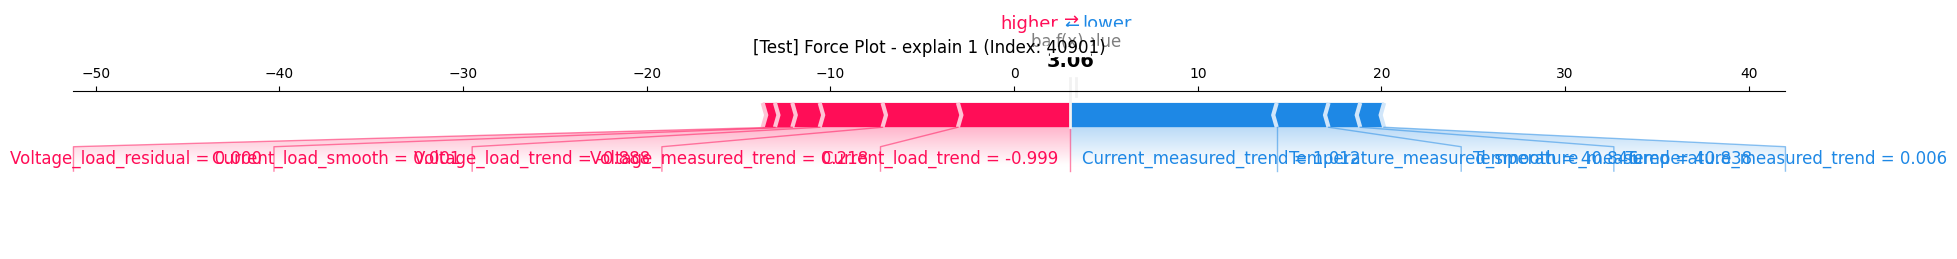


Force Plot 2


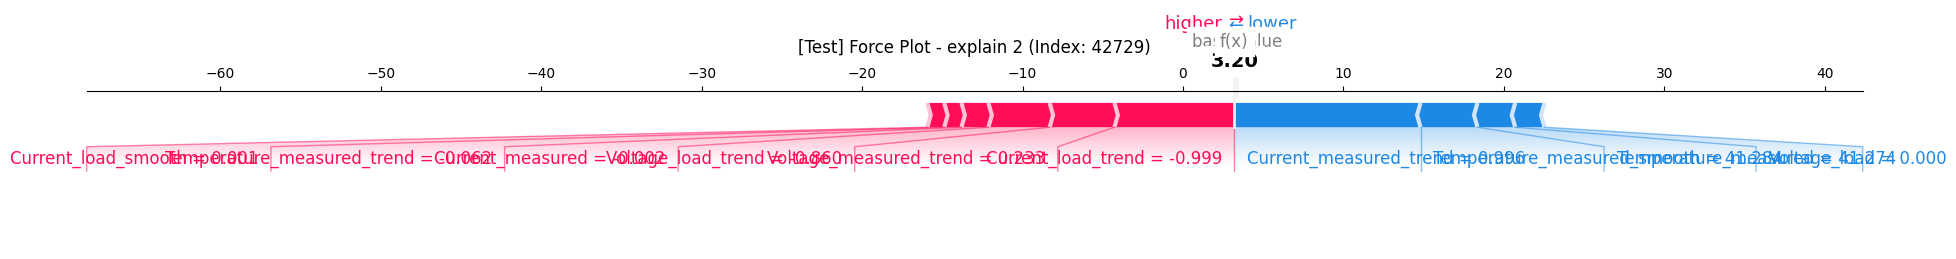


Force Plot 3


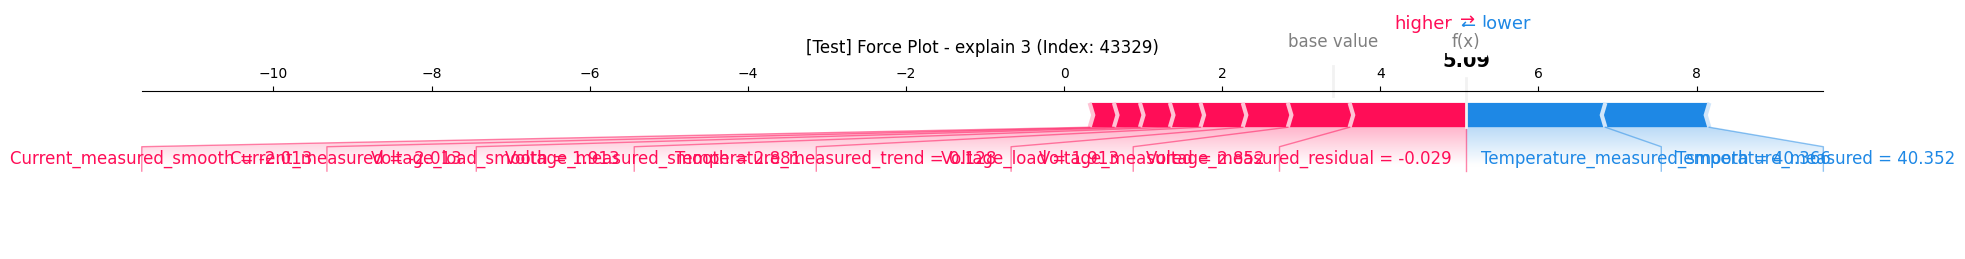


 [Test] SHAP Analysis 완료!


In [30]:
shap_test, X_test_explain, base_test = run_lof_shap_for_split(
    split_name="Test",
    df_split=test_df,
    scores_split=test_scores,
    threshold=threshold,   # 똑같은 threshold 재사용
    explainer=explainer,
    feature_cols=features1
)

In [31]:
test_df['lof_score']=test_scores

# Z-Deviation

In [32]:
import numpy as np

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

def compute_feature_deviation_by_split(df_split, features,threshold,scores_split,split_name="Split"):
    """
    하나의 구간(df_split: val_df 또는 test_df) 안에서
    - 정상(lof_anomaly=0)을 baseline으로 두고
    - 이상(lof_anomaly=1)의 z-score deviation을 계산함.
    """
    df_split = df_split.copy()
    
    # 1) 점수 & 이상치 플래그
    df_split['lof_score'] = scores_split
    df_split['is_anom'] = df_split['lof_score'] >= threshold

   
    # 1) 정상 / 이상 윈도우 나누기
    normal_df = df_split[df_split['is_anom'] == False]
    anom_df   = df_split[df_split['is_anom'] == True]

    print(f"\n===== [{split_name}] deviation 분석 =====")
    print(f"정상 윈도우 수: {len(normal_df)}")
    print(f"이상 윈도우 수: {len(anom_df)}")

    if len(normal_df) == 0 or len(anom_df) == 0:
        print(f" [{split_name}] 구간에 정상 또는 이상 윈도우가 부족해서 deviation 계산 불가")
        return None

    # 2) baseline (정상 구간) 평균 / 표준편차
    baseline_mean = normal_df[features].mean()
    baseline_std  = normal_df[features].std()

    # 표준편차 0인 경우 분모가 0 되는 것을 방지
    baseline_std_replaced = baseline_std.replace(0, np.nan)

    # 3) 이상 구간의 z-score 형태 deviation
    z_deviation = ((anom_df[features] - baseline_mean) / baseline_std_replaced).abs()

    # 4) feature별 평균 deviation (큰 순으로 정렬)
    feature_deviation_mean = z_deviation.mean(axis=0).sort_values(ascending=False)

    print("\n[", split_name, "] feature deviation (상위 10개):")
    print(feature_deviation_mean.head(10))

    return feature_deviation_mean


In [33]:
q = 0.999
threshold = np.quantile(val_scores, q)
print("사용할 threshold:", threshold)


# Validation 구간 deviation
val_deviation = compute_feature_deviation_by_split(
    df_split=val_df,
    features=features,
    scores_split=val_scores,
    threshold=threshold,
    split_name="Validation"
    
)

# Test 구간 deviation
test_deviation = compute_feature_deviation_by_split(
    df_split=test_df,
    features=features,
    scores_split=test_scores,
    threshold=threshold,
    split_name="Test"
)

사용할 threshold: 3.537997666777979

===== [Validation] deviation 분석 =====
정상 윈도우 수: 10653
이상 윈도우 수: 11

[ Validation ] feature deviation (상위 10개):
Voltage_measured_trend         7.541292
Current_measured_trend         5.948506
Current_load_trend             5.391923
Voltage_load_trend             4.066670
Voltage_measured_smooth        2.033801
Voltage_measured               2.019914
Temperature_measured           1.925877
Temperature_measured_smooth    1.920764
Voltage_load                   1.607367
Voltage_load_smooth            1.514242
dtype: float64

===== [Test] deviation 분석 =====
정상 윈도우 수: 10206
이상 윈도우 수: 54

[ Test ] feature deviation (상위 10개):
Voltage_measured               1.625971
Voltage_measured_smooth        1.583761
Temperature_measured_smooth    1.504355
Temperature_measured           1.499398
Temperature_measured_trend     1.173638
Voltage_measured_trend         1.097982
Voltage_load                   1.020944
Voltage_load_smooth            1.016618
Voltage_measured_res

# feature importance (RandomForest)

In [34]:
# 1. 데이터 준비
features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

X = full[features]
y = full['is_anom'].astype(int)

print(f"\n전체 데이터: {len(X)}개")
print(f"이상치: {y.sum()}개 ({y.sum()/len(y)*100:.2f}%)")

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. RandomForest 학습
print("\nRandomForest Surrogate 학습 중...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_scaled, y)

# 4. Feature Importance 계산
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance_df)

# 5. Plotly 시각화 (방법 1: 간단한 bar chart)
fig = px.bar(
    feature_importance_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Feature Importances (Random Forest)',
    labels={'Importance': 'Importance Score', 'Feature': 'Feature Name'},
    color='Importance',
    color_continuous_scale='Blues'
)
fig.update_layout(
    height=400,
    showlegend=False,
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()



전체 데이터: 50285개
이상치: 127개 (0.25%)

RandomForest Surrogate 학습 중...

=== Feature Importance ===
                          Feature  Importance
19             Voltage_load_trend    0.118453
13     Temperature_measured_trend    0.113381
7          Voltage_measured_trend    0.094875
12  Temperature_measured_residual    0.071194
0                Voltage_measured    0.070180
11    Temperature_measured_smooth    0.068939
5         Voltage_measured_smooth    0.063618
14            Current_load_smooth    0.063385
2            Temperature_measured    0.052858
4                    Voltage_load    0.049677
3                    Current_load    0.047339
17            Voltage_load_smooth    0.043244
18          Voltage_load_residual    0.029702
6       Voltage_measured_residual    0.022346
1                Current_measured    0.021302
10         Current_measured_trend    0.019239
8         Current_measured_smooth    0.017003
9       Current_measured_residual    0.013290
16             Current_load_tren

In [36]:
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_scaled, full['score'])   # score 자체를 예측
y_pred_reg = rf_model.predict(X_scaled)

print("Pearson:", pearsonr(full['score'], y_pred_reg))
print("Spearman:", spearmanr(full['score'], y_pred_reg))

Pearson: PearsonRResult(statistic=np.float64(0.9937643619756164), pvalue=np.float64(0.0))
Spearman: SignificanceResult(statistic=np.float64(0.9917627043919593), pvalue=np.float64(0.0))


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, full['score'], test_size=0.2)
rf_model.fit(X_train, y_train)
y_pred_test = rf_model.predict(X_test)
print(pearsonr(y_test, y_pred_test))
print(spearmanr(y_test, y_pred_test))

PearsonRResult(statistic=np.float64(0.9389833209044568), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9373883328162084), pvalue=np.float64(0.0))


# JSD + KDE 기반 deviation 함수

In [38]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# -----------------------------
# 1) JSD 계산용 헬퍼 함수
# -----------------------------
def js_divergence(p, q, eps=1e-12):
    """
    p, q: 같은 길이의 1D 확률분포 (합이 1인 상태를 가정)
    JSD(P, Q) = 0.5 * KL(P || M) + 0.5 * KL(Q || M), M = (P+Q)/2
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    
    # 정규화 (혹시 모를 sum != 1 방지)
    p = p / (p.sum() + eps)
    q = q / (q.sum() + eps)
    
    m = 0.5 * (p + q)
    
    jsd = 0.5 * np.sum(p * np.log((p + eps) / (m + eps))) + \
          0.5 * np.sum(q * np.log((q + eps) / (m + eps)))
    return jsd


# -----------------------------
# 2) KDE 기반 density deviation (feature 단위)
# -----------------------------
def compute_density_deviation_jsd(
    df_split,
    features,
    scores_split,
    threshold,
    split_name="Validation",
    grid_size=200
):
    """
    df_split   : 현재 split (val/test 등) 데이터프레임
    features   : 분석할 feature 리스트
    scores_split: LOF anomaly score (df_split과 길이 동일한 1D array-like)
    threshold  : LOF threshold (이상치 기준)
    split_name : 출력용 이름
    grid_size  : KDE를 평가할 grid 개수 (클수록 정밀하지만 느려짐)
    """
    
    df = df_split.copy()
    df["lof_score"] = scores_split
    df["is_anom"] = df["lof_score"] >= threshold
    
    normal_df = df.loc[~df["is_anom"], features]
    anom_df   = df.loc[df["is_anom"],  features]
    
    print(f"\n===== [{split_name}] density-based deviation (KDE + JSD) =====")
    print(f"정상 윈도우 수: {len(normal_df)}")
    print(f"이상 윈도우 수: {len(anom_df)}")
    
    # 정상/이상 데이터가 너무 적으면 반환 X
    if len(normal_df) < 10 or len(anom_df) < 5:
        print(f"[{split_name}] 정상/이상 샘플 수가 부족해 KDE 기반 deviation 계산 불가")
        return None
    
    results = []
    
    for col in features:
        x_norm = normal_df[col].dropna().values
        x_anom = anom_df[col].dropna().values
        
        # 값이 너무 단조롭거나, 유일 값이 1개 이하인 경우 스킵
        all_vals = np.concatenate([x_norm, x_anom])
        if len(np.unique(all_vals)) < 2:
            print(f" - {col}: 유니크 값이 너무 적어 스킵")
            continue
        
        # 공통 grid 설정 (정상+이상 전체 범위 기준)
        vmin, vmax = np.min(all_vals), np.max(all_vals)
        grid = np.linspace(vmin, vmax, grid_size)
        
        # 1D KDE 추정
        try:
            kde_norm = gaussian_kde(x_norm)
            kde_anom = gaussian_kde(x_anom)
        except Exception as e:
            print(f" - {col}: KDE 실패 ({e}) -> 스킵")
            continue
        
        p = kde_norm(grid)
        q = kde_anom(grid)
        
        # 음수/NaN 방지
        p = np.clip(p, 0, None)
        q = np.clip(q, 0, None)
        
        # JSD 계산 (값이 클수록 '정상 vs 이상' 밀도 차이가 큼)
        jsd = js_divergence(p, q)
        
        results.append({"feature": col, "jsd_density_deviation": jsd})
    
    if not results:
        print(f"[{split_name}] 계산된 feature가 없습니다.")
        return None
    
    dev_df = pd.DataFrame(results).sort_values(
        "jsd_density_deviation", ascending=False
    ).reset_index(drop=True)
    
    print("\n[상위 feature (density 차이 순)]")
    print(dev_df.head(10))
    
    return dev_df

In [39]:
q = 0.999
threshold = np.quantile(val_scores, q)
print("사용할 threshold:", threshold)

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Voltage_measured_smooth',
    'Voltage_measured_residual', 'Voltage_measured_trend',
    'Current_measured_smooth', 'Current_measured_residual',
    'Current_measured_trend', 'Temperature_measured_smooth',
    'Temperature_measured_residual', 'Temperature_measured_trend',
    'Current_load_smooth', 'Current_load_residual', 'Current_load_trend',
    'Voltage_load_smooth', 'Voltage_load_residual', 'Voltage_load_trend'
]

# 예: Validation split 에서 LOF 결과가 scores_val, 데이터가 val_df 라고 가정
density_dev_val = compute_density_deviation_jsd(
    df_split=val_df,
    features=features,
    scores_split=val_scores,  # LOF score 배열
    threshold=threshold, 
    split_name="Validation",
    grid_size=200
)

# Test에서도 똑같이
density_dev_test = compute_density_deviation_jsd(
    df_split=test_df,
    features=features,
    scores_split=test_scores,
    threshold=threshold,
    split_name="Test",
    grid_size=200
)


사용할 threshold: 3.537997666777979

===== [Validation] density-based deviation (KDE + JSD) =====
정상 윈도우 수: 10653
이상 윈도우 수: 11

[상위 feature (density 차이 순)]
                     feature  jsd_density_deviation
0     Current_measured_trend               0.572548
1         Current_load_trend               0.566172
2         Voltage_load_trend               0.541272
3     Voltage_measured_trend               0.469019
4  Current_measured_residual               0.387150
5      Voltage_load_residual               0.386673
6               Current_load               0.370253
7    Current_measured_smooth               0.368242
8           Current_measured               0.365889
9        Current_load_smooth               0.361050

===== [Test] density-based deviation (KDE + JSD) =====
정상 윈도우 수: 10206
이상 윈도우 수: 54

[상위 feature (density 차이 순)]
                     feature  jsd_density_deviation
0      Current_load_residual               0.400241
1         Current_load_trend               0.390958
2    

In [32]:
cycle_anomaly = (
    full.groupby('cycle_idx')['score']
        .agg(mean_score='mean', 
             median_score='median', 
             max_score='max')
        .reset_index()
)

In [34]:
raw_discharge_df=pd.read_csv('/Users/gimhagyeong/test/B0005_discharge.csv')

In [35]:
cycle_anomaly

cycle_idx  mean_score  median_score  max_score
0            2    1.131456      1.096262   1.654330
1            4    1.117758      1.091529   1.941832
2            6    1.130816      1.055099   5.891674
3            8    1.092035      1.016034   6.126168
4           10    1.109424      1.001969  12.788607
..         ...         ...           ...        ...
163        600    2.167378      2.082073   3.923075
164        604    2.194079      2.040987   4.048687
165        608    2.198891      2.069808   3.679316
166        612    1.773032      1.628673   3.411143
167        614    1.681845      1.577065   4.939428

[168 rows x 4 columns]

In [36]:
capacity_cycle = (
    raw_discharge_df
      .groupby('cycle_idx')['Capacity']
      .agg('max')               # 또는 'first'
      .reset_index()
)

In [37]:
merged = cycle_anomaly.merge(capacity_cycle[['cycle_idx','Capacity']], on='cycle_idx')


In [38]:
merged

cycle_idx  mean_score  median_score  max_score  Capacity
0            2    1.131456      1.096262   1.654330  1.856487
1            4    1.117758      1.091529   1.941832  1.846327
2            6    1.130816      1.055099   5.891674  1.835349
3            8    1.092035      1.016034   6.126168  1.835263
4           10    1.109424      1.001969  12.788607  1.834646
..         ...         ...           ...        ...       ...
163        600    2.167378      2.082073   3.923075  1.293464
164        604    2.194079      2.040987   4.048687  1.288003
165        608    2.198891      2.069808   3.679316  1.287453
166        612    1.773032      1.628673   3.411143  1.309015
167        614    1.681845      1.577065   4.939428  1.325079

[168 rows x 5 columns]

In [39]:
merged_anomal=merged[merged['cycle_idx']>352]
print(merged_anomal[['mean_score','Capacity']].corr(method='pearson'))
print(merged_anomal[['mean_score','Capacity']].corr(method='spearman'))
print(merged_anomal[['mean_score','Capacity']].corr(method='kendall'))
print("="*70)
print(merged_anomal[['median_score','Capacity']].corr(method='pearson'))
print(merged_anomal[['median_score','Capacity']].corr(method='spearman'))
print(merged_anomal[['median_score','Capacity']].corr(method='kendall'))
print("="*70)
print(merged_anomal[['max_score','Capacity']].corr(method='pearson'))
print(merged_anomal[['max_score','Capacity']].corr(method='spearman'))
print(merged_anomal[['max_score','Capacity']].corr(method='kendall'))

            mean_score  Capacity
mean_score    1.000000 -0.953266
Capacity     -0.953266  1.000000
            mean_score  Capacity
mean_score    1.000000 -0.973318
Capacity     -0.973318  1.000000
            mean_score  Capacity
mean_score    1.000000 -0.875329
Capacity     -0.875329  1.000000
              median_score  Capacity
median_score      1.000000 -0.920061
Capacity         -0.920061  1.000000
              median_score  Capacity
median_score      1.000000 -0.943505
Capacity         -0.943505  1.000000
              median_score  Capacity
median_score      1.000000 -0.804214
Capacity         -0.804214  1.000000
           max_score  Capacity
max_score   1.000000 -0.405198
Capacity   -0.405198  1.000000
           max_score  Capacity
max_score   1.000000 -0.447647
Capacity   -0.447647  1.000000
           max_score  Capacity
max_score    1.00000  -0.32309
Capacity    -0.32309   1.00000


In [40]:
def get_r_ohmic(cycle_df):
    # 1) Rest (I ≈ 0)
    rest = cycle_df[np.abs(cycle_df['Current_load']) < 0.01]
    V_initial = rest['Voltage_measured'].iloc[-1]

    # 2) Load 시작
    load = cycle_df[np.abs(cycle_df['Current_load']) > 0.5]
    V_start = load['Voltage_measured'].iloc[0]
    I_start = load['Current_load'].iloc[0]   # ✔ 순간 전류 사용

    IR_drop = V_initial - V_start
    R_ohmic = IR_drop / abs(I_start)

    return R_ohmic


In [41]:
# cycle 단위 R_ohmic 계산
r_df = (
    raw_discharge_df
        .groupby('cycle_idx')
        .apply(get_r_ohmic)          # 각 cycle_df가 함수에 들어감
        .reset_index(name='R_ohmic') # 결과 컬럼 이름 지정
)


/var/folders/vf/9p8syxcx1g77s8jzp8b8b8fh0000gn/T/ipykernel_49001/735748042.py:5: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [42]:
r_df

cycle_idx   R_ohmic
0            2 -0.349165
1            4 -0.339728
2            6 -0.326566
3            8 -0.334016
4           10 -0.338683
..         ...       ...
163        600 -0.177607
164        604 -0.174304
165        608 -0.175328
166        612 -0.184868
167        614 -0.196318

[168 rows x 2 columns]

In [43]:
merged = cycle_anomaly.merge(r_df, on='cycle_idx', how='inner')
# 353 cycle 이상만 사용
merged_anomal2 = merged[merged['cycle_idx'] > 352].dropna()

In [44]:
for col in ['mean_score', 'median_score', 'max_score']:
    print(f"=== {col} vs R_ohmic ===")
    for method in ['pearson', 'spearman', 'kendall']:
        print(f"\n{method}")
        print(merged_anomal2[[col, 'R_ohmic']].corr(method=method))
    print("="*70)

=== mean_score vs R_ohmic ===

pearson
            mean_score   R_ohmic
mean_score    1.000000  0.920269
R_ohmic       0.920269  1.000000

spearman
            mean_score   R_ohmic
mean_score    1.000000  0.952552
R_ohmic       0.952552  1.000000

kendall
            mean_score   R_ohmic
mean_score    1.000000  0.822651
R_ohmic       0.822651  1.000000
=== median_score vs R_ohmic ===

pearson
              median_score   R_ohmic
median_score      1.000000  0.887486
R_ohmic           0.887486  1.000000

spearman
              median_score   R_ohmic
median_score      1.000000  0.917891
R_ohmic           0.917891  1.000000

kendall
              median_score   R_ohmic
median_score      1.000000  0.760316
R_ohmic           0.760316  1.000000
=== max_score vs R_ohmic ===

pearson
           max_score   R_ohmic
max_score   1.000000  0.377312
R_ohmic     0.377312  1.000000

spearman
           max_score   R_ohmic
max_score   1.000000  0.408482
R_ohmic     0.408482  1.000000

kendall
         

In [45]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

selected_quantile = 0.999
threshold = np.quantile(val_scores, selected_quantile)


# 1. 점수 & split 정보 붙이기
train_plot = train_df.copy()
val_plot   = val_df.copy()
test_plot  = test_df.copy()

train_plot['score'] = train_scores
val_plot['score']   = val_scores
test_plot['score']  = test_scores

train_plot['split'] = 'train'
val_plot['split']   = 'val'
test_plot['split']  = 'test'

full = pd.concat([train_plot, val_plot, test_plot], ignore_index=True)

# 이상치 여부
full['is_anom'] = full['score'] >= threshold

# 2. cycle 단위 요약 (예: max score, 이상치 비율)
cycle_summary = (
    full.groupby(['split', 'cycle_idx'])
        .agg(
            max_score=('score', 'max'),
            mean_score=('score', 'mean'),
            frac_anom=('is_anom', 'mean')   # 해당 cycle 내 이상치 비율
        )
        .reset_index()
)

# cycle에 하나라도 이상치 있으면 True
cycle_summary['has_anom'] = cycle_summary['frac_anom'] > 0
cycle_summary['has_anom'] = cycle_summary['has_anom'].map({True: 'anomaly cycle', False: 'normal cycle'})

# 3. cycle-wise anomaly plot (max score 기준)
fig = px.scatter(
    cycle_summary,
    x='cycle_idx',
    y='mean_score',
    color='split',            # train/val/test 구분
    symbol='has_anom',        # 이상 cycle 표시
    hover_data=['frac_anom', 'mean_score'],
    title='Cycle-wise LOF anomaly (max score per cycle)'
)

# threshold 수평선 추가
fig.add_hline(
    y=thr,
    line_dash='dash',
    line_color='red',
    annotation_text=f'threshold={threshold:.4f}',
    annotation_position='top left'
)

fig.update_layout(xaxis_title='cycle_idx', yaxis_title='max LOF score')
fig.show()


mean anomaly score는 cycle 내 anomaly의 평균적 강도를 나타내는 연속 지표로,
event 판정을 위한 threshold를 넘는 것을 목표로 하지 않음.
threshold는 max anomaly score와 같이 국소적 spike 탐지를 위한 지표에만 적용되며,
mean/median score는 열화의 점진적 진행을 모니터링하기 위한 HI 구성에 사용됨.

한 줄로 정리

mean score가 threshold 아래에 있는 건 “이상한 결과”가 아니라,
지금 분석이 event detection에서 degradation monitoring으로 넘어갔다는 신호다.

In [46]:
full

Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0              4.191492         -0.004902             24.330034       -0.0006   
1              4.190749         -0.001478             24.325993       -0.0006   
2              3.974871         -2.012528             24.389085       -1.9982   
3              3.951717         -2.013979             24.544752       -1.9982   
4              3.934352         -2.011144             24.731385       -1.9982   
...                 ...               ...                   ...           ...   
50280          3.579262         -0.001569             34.864823        0.0006   
50281          3.581964         -0.003067             34.814770        0.0006   
50282          3.584484         -0.003079             34.676258        0.0006   
50283          3.587336          0.001219             34.565580        0.0006   
50284          3.589937         -0.000583             34.405920        0.0006   

       Voltage_load  cycle_idx  Voltage_measured_smooth  \
0             0.000          2                 4.191492   
1             4.206          2                 4.190749   
2             3.062          2                 3.974871   
3             3.030          2                 3.951717   
4             3.011          2                 3.934352   
...             ...        ...                      ...   
50280         0.000        614                 3.578546   
50281         0.000        614                 3.581578   
50282         0.000        614                 3.584602   
50283         0.000        614                 3.587614   
50284         0.000        614                 3.590615   

       Voltage_measured_residual  Voltage_measured_trend  \
0                       0.000000               -0.000743   
1                       0.000000               -0.108310   
2                       0.000000               -0.119516   
3                       0.000000               -0.020259   
4                       0.000000               -0.015829   
...                          ...                     ...   
50280                   0.000716                0.003035   
50281                   0.000386                0.003028   
50282                  -0.000118                0.003018   
50283                  -0.000278                0.003007   
50284                  -0.000677                0.003001   

       Current_measured_smooth  ...  Current_load_trend  Voltage_load_smooth  \
0                    -2.012707  ...        3.108624e-14                0.000   
1                    -2.012723  ...        3.774758e-15                4.206   
2                    -2.012746  ...       -1.232348e-14                3.062   
3                    -2.012799  ...        0.000000e+00                3.030   
4                    -2.012904  ...        1.110223e-15                3.011   
...                        ...  ...                 ...                  ...   
50280                -0.000686  ...       -7.047314e-19                0.000   
50281                -0.000689  ...       -7.047314e-19                0.000   
50282                -0.000717  ...       -1.192622e-18                0.000   
50283                -0.000761  ...       -5.149960e-18                0.000   
50284                -0.000810  ...       -1.160096e-17                0.000   

       Voltage_load_residual  Voltage_load_trend  lof_scores  lof_anomaly  \
0                        0.0              4.2060    0.989095            0   
1                        0.0              1.5310    1.000591            0   
2                        0.0             -0.5880    1.025896            0   
3                        0.0             -0.0255    1.087122            0   
4                        0.0             -0.0195    1.057250            0   
...                      ...                 ...         ...          ...   
50280                    0.0              0.0000    5.057295            1   
50281                    0.

In [79]:
import numpy as np
import pandas as pd

df = cycle_anomaly.copy()

# 0) split 컬럼이 없으면 cycle_idx로 만들어주기
# (이미 split이 있으면 이 블록은 건너뛰어도 됨)
if 'split' not in df.columns:
    df['split'] = np.select(
        [
            (df['cycle_idx'] >= 0) & (df['cycle_idx'] <= 352),
            (df['cycle_idx'] >= 353) & (df['cycle_idx'] <= 483),
            (df['cycle_idx'] >= 484) & (df['cycle_idx'] <= 614),
        ],
        ['train', 'val', 'test'],
        default='other'
    )

# 1) 어떤 score로 HI 만들지 선택 (b0005면 보통 mean_score 추천)
score_col = 'mean_score'   # 'median_score'로 바꿔도 됨

train_mask = df['split'].eq('train')
val_mask   = df['split'].eq('val')
test_mask  = df['split'].eq('test')

# 2) train 기준 robust 정규화 파라미터
train_scores = df.loc[train_mask, score_col].astype(float)

med = train_scores.median()
q1  = train_scores.quantile(0.25)
q3  = train_scores.quantile(0.75)
iqr = (q3 - q1) if (q3 - q1) != 0 else 1e-8

# 3) 정상 대비 이탈(robust z) -> 음수 제거 -> log 압축
df['z_t'] = (df[score_col].astype(float) - med) / iqr
df['s_t'] = df['z_t'].clip(lower=0)
df['s_t_log'] = np.log1p(df['s_t'])

# 4) HI(EMA): val, test 각각 0에서 시작
alpha = 0.2
df['HI_ema'] = np.nan

def ema_with_init(arr, alpha, init=0.0):
    hi = np.zeros_like(arr, dtype=float)
    hi[0] = init
    for i in range(1, len(arr)):
        hi[i] = alpha * arr[i] + (1 - alpha) * hi[i-1]
    return hi

# val HI (0에서 시작)
val_arr = df.loc[val_mask, 's_t_log'].to_numpy(dtype=float)
val_hi = ema_with_init(val_arr, alpha, init=0.0)
df.loc[val_mask, 'HI_ema'] = val_hi

# test HI (val 마지막 값에서 이어받기)
test_arr = df.loc[test_mask, 's_t_log'].to_numpy(dtype=float)
init_test = val_hi[-1]  # ⭐ 핵심
test_hi = ema_with_init(test_arr, alpha, init=init_test)
df.loc[test_mask, 'HI_ema'] = test_hi

df


cycle_idx  mean_score  median_score  max_score  split        z_t  \
0            2    1.131456      1.096262   1.654330  train   0.666271   
1            4    1.117758      1.091529   1.941832  train   0.498523   
2            6    1.130816      1.055099   5.891674  train   0.658442   
3            8    1.092035      1.016034   6.126168  train   0.183500   
4           10    1.109424      1.001969  12.788607  train   0.396465   
..         ...         ...           ...        ...    ...        ...   
163        600    2.167378      2.082073   3.923075   test  13.352795   
164        604    2.194079      2.040987   4.048687   test  13.679790   
165        608    2.198891      2.069808   3.679316   test  13.738720   
166        612    1.773032      1.628673   3.411143   test   8.523392   
167        614    1.681845      1.577065   4.939428   test   7.406662   

           s_t   s_t_log    HI_ema  
0     0.666271  0.510588       NaN  
1     0.498523  0.404480       NaN  
2     0.658442  0.505879       NaN  
3     0.183500  0.168476       NaN  
4     0.396465  0.333944       NaN  
..         ...       ...       ...  
163  13.352795  2.663945  2.583054  
164  13.679790  2.686472  2.603738  
165  13.738720  2.690478  2.621086  
166   8.523392  2.253751  2.547619  
167   7.406662  2.129024  2.463900  

[168 rows x 9 columns]

In [80]:
hi_merged=df.merge(r_df, on='cycle_idx', how='inner')
hi_merged=hi_merged.merge(capacity_cycle, on='cycle_idx', how='inner')
hi_merged = hi_merged[hi_merged['cycle_idx'] > 352].dropna()

In [81]:
print(hi_merged[['HI_ema','R_ohmic']].corr(method='pearson'))
print(hi_merged[['HI_ema','R_ohmic']].corr(method='spearman'))
print(hi_merged[['HI_ema','R_ohmic']].corr(method='kendall'))

           HI_ema   R_ohmic
HI_ema   1.000000  0.904326
R_ohmic  0.904326  1.000000
           HI_ema   R_ohmic
HI_ema   1.000000  0.922604
R_ohmic  0.922604  1.000000
           HI_ema   R_ohmic
HI_ema   1.000000  0.791392
R_ohmic  0.791392  1.000000


In [82]:
hi_merged

cycle_idx  mean_score  median_score  max_score split        z_t  \
100        356    1.041919      1.024173   1.403090   val  -0.430253   
101        360    1.066462      1.041889   1.522469   val  -0.129681   
102        364    1.094211      1.058839   3.310529   val   0.210157   
103        367    1.301780      1.250749   3.192214   val   2.752161   
104        371    1.259828      1.246566   3.650730   val   2.238400   
..         ...         ...           ...        ...   ...        ...   
163        600    2.167378      2.082073   3.923075  test  13.352795   
164        604    2.194079      2.040987   4.048687  test  13.679790   
165        608    2.198891      2.069808   3.679316  test  13.738720   
166        612    1.773032      1.628673   3.411143  test   8.523392   
167        614    1.681845      1.577065   4.939428  test   7.406662   

           s_t   s_t_log    HI_ema   R_ohmic  Capacity  
100   0.000000  0.000000  0.000000 -0.214631  1.480414  
101   0.000000  0.000000  0.000000 -0.214076  1.475210  
102   0.210157  0.190751  0.038150 -0.220769  1.485904  
103   2.752161  1.322332  0.294986 -0.231378  1.496092  
104   2.238400  1.175079  0.471005 -0.223750  1.480801  
..         ...       ...       ...       ...       ...  
163  13.352795  2.663945  2.583054 -0.177607  1.293464  
164  13.679790  2.686472  2.603738 -0.174304  1.288003  
165  13.738720  2.690478  2.621086 -0.175328  1.287453  
166   8.523392  2.253751  2.547619 -0.184868  1.309015  
167   7.406662  2.129024  2.463900 -0.196318  1.325079  

[68 rows x 11 columns]

In [83]:
print(hi_merged[['HI_ema','Capacity']].corr(method='pearson'))
print(hi_merged[['HI_ema','Capacity']].corr(method='spearman'))
print(hi_merged[['HI_ema','Capacity']].corr(method='kendall'))

            HI_ema  Capacity
HI_ema    1.000000 -0.968408
Capacity -0.968408  1.000000
            HI_ema  Capacity
HI_ema    1.000000 -0.982326
Capacity -0.982326  1.000000
            HI_ema  Capacity
HI_ema    1.000000 -0.909091
Capacity -0.909091  1.000000


In [84]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ========================================
# 1) Validation 구간 추출 (cycle_idx >= 353)
# ========================================
val_test_df = hi_merged[hi_merged['cycle_idx'] >= 353].copy().reset_index(drop=True)

print("=== 데이터 정보 ===")
print(f"Validation/Test 구간: Cycle {val_test_df['cycle_idx'].min()} ~ {val_test_df['cycle_idx'].max()}")
print(f"총 {len(val_test_df)} cycles")

# ========================================
# 2) HI_ema 기울기 계산
# ========================================
val_test_df['HI_slope'] = val_test_df['HI_ema'].diff()

# 이동평균으로 노이즈 제거 (5-cycle window)
val_test_df['HI_slope_ma'] = val_test_df['HI_slope'].rolling(window=5, min_periods=1).mean()

# ========================================
# 3) R_ohmic 변화 분석
# ========================================
val_test_df['R_ohmic_diff'] = val_test_df['R_ohmic'].diff()
val_test_df['R_ohmic_pct'] = val_test_df['R_ohmic'].pct_change() * 100

# ========================================
# 4) Capacity 변화 분석
# ========================================
val_test_df['Capacity_diff'] = val_test_df['Capacity'].diff()
val_test_df['Capacity_pct'] = val_test_df['Capacity'].pct_change() * 100

# ========================================
# 5) 599 cycle 근처 급변 지점 찾기
# ========================================
# 590~614 구간 집중 분석
around_599 = val_test_df[
    (val_test_df['cycle_idx'] >= 580) & 
    (val_test_df['cycle_idx'] <= 614)
].copy()

print("\n=== 599 Cycle 근처 분석 (580~614) ===")
print(f"구간 데이터: {len(around_599)} cycles")

# R_ohmic 급증 찾기
r_spike_threshold = around_599['R_ohmic_diff'].quantile(0.90)
r_spikes = around_599[around_599['R_ohmic_diff'] > r_spike_threshold]

print(f"\n[R_ohmic 급증 감지] (임계값: {r_spike_threshold:.6f})")
if len(r_spikes) > 0:
    for idx, row in r_spikes.iterrows():
        print(f"  Cycle {row['cycle_idx']:.0f}: "
              f"R_ohmic={row['R_ohmic']:.4f} "
              f"(증가: {row['R_ohmic_diff']:.6f}, {row['R_ohmic_pct']:.2f}%)")
else:
    print("  급증 없음")

# Capacity 급락 찾기
cap_drop_threshold = around_599['Capacity_diff'].quantile(0.10)
cap_drops = around_599[around_599['Capacity_diff'] < cap_drop_threshold]

print(f"\n[Capacity 급락 감지] (임계값: {cap_drop_threshold:.6f})")
if len(cap_drops) > 0:
    for idx, row in cap_drops.iterrows():
        print(f"  Cycle {row['cycle_idx']:.0f}: "
              f"Capacity={row['Capacity']:.4f} "
              f"(감소: {row['Capacity_diff']:.6f}, {row['Capacity_pct']:.2f}%)")
else:
    print("  급락 없음")

# ========================================
# 6) 전체 구간에서 가장 큰 변화 찾기
# ========================================
print("\n=== 전체 Validation 구간 이상 징후 ===")

# R_ohmic 최대 증가
max_r_increase = val_test_df.loc[val_test_df['R_ohmic_diff'].idxmax()]
print(f"\n[R_ohmic 최대 증가]")
print(f"  Cycle {max_r_increase['cycle_idx']:.0f}: "
      f"증가량 {max_r_increase['R_ohmic_diff']:.6f} "
      f"({max_r_increase['R_ohmic_pct']:.2f}%)")

# Capacity 최대 감소
max_cap_decrease = val_test_df.loc[val_test_df['Capacity_diff'].idxmin()]
print(f"\n[Capacity 최대 감소]")
print(f"  Cycle {max_cap_decrease['cycle_idx']:.0f}: "
      f"감소량 {max_cap_decrease['Capacity_diff']:.6f} "
      f"({max_cap_decrease['Capacity_pct']:.2f}%)")

# ========================================
# 7) HI_ema 조기 경고 분석
# ========================================
print("\n=== HI_ema 조기 경고 분석 ===")

# HI 기울기가 크게 증가한 시점들
hi_slope_threshold = val_test_df['HI_slope_ma'].quantile(0.85)
hi_alerts = val_test_df[val_test_df['HI_slope_ma'] > hi_slope_threshold].copy()

print(f"\nHI 기울기 임계값: {hi_slope_threshold:.6f}")
print(f"경고 발생: {len(hi_alerts)}회")

# 리드타임 계산 (R_ohmic 급증 기준)
if len(r_spikes) > 0:
    r_spike_cycle = r_spikes['cycle_idx'].iloc[0]  # 첫 번째 spike
    
    # 해당 spike 이전의 HI 경고들
    prior_alerts = hi_alerts[hi_alerts['cycle_idx'] < r_spike_cycle]
    
    if len(prior_alerts) > 0:
        first_alert_cycle = prior_alerts['cycle_idx'].iloc[0]
        lead_time = r_spike_cycle - first_alert_cycle
        
        print(f"\n🎯 리드타임 발견!")
        print(f"  첫 HI 경고: Cycle {first_alert_cycle:.0f}")
        print(f"  R_ohmic 급증: Cycle {r_spike_cycle:.0f}")
        print(f"  → 리드타임: {lead_time:.0f} cycles")
        
        # 마지막 HI 경고
        last_alert_cycle = prior_alerts['cycle_idx'].iloc[-1]
        min_lead_time = r_spike_cycle - last_alert_cycle
        print(f"  마지막 HI 경고: Cycle {last_alert_cycle:.0f}")
        print(f"  → 최소 리드타임: {min_lead_time:.0f} cycles")
    else:
        print("\n⚠️ R_ohmic 급증 이전에 HI 경고 없음")
else:
    print("\n⚠️ R_ohmic 급증 미감지")

# ========================================
# 8) 시각화
# ========================================
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=('R_ohmic', 'Capacity', 'HI_ema', 'HI 기울기'),
    vertical_spacing=0.08,
    specs=[[{"secondary_y": False}],
           [{"secondary_y": False}],
           [{"secondary_y": False}],
           [{"secondary_y": False}]]
)

# Row 1: R_ohmic
fig.add_trace(
    go.Scatter(x=val_test_df['cycle_idx'], y=val_test_df['R_ohmic'],
               name='R_ohmic', line=dict(color='red', width=2)),
    row=1, col=1
)

# R_ohmic spike 표시
if len(r_spikes) > 0:
    for idx, row in r_spikes.iterrows():
        fig.add_vline(
            x=row['cycle_idx'], line=dict(color='red', dash='dash', width=2),
            annotation_text=f"Spike", row=1, col=1
        )

# Row 2: Capacity
fig.add_trace(
    go.Scatter(x=val_test_df['cycle_idx'], y=val_test_df['Capacity'],
               name='Capacity', line=dict(color='green', width=2)),
    row=2, col=1
)

# Row 3: HI_ema
fig.add_trace(
    go.Scatter(x=val_test_df['cycle_idx'], y=val_test_df['HI_ema'],
               name='HI_ema', line=dict(color='blue', width=2)),
    row=3, col=1
)

# Row 4: HI 기울기
fig.add_trace(
    go.Scatter(x=val_test_df['cycle_idx'], y=val_test_df['HI_slope_ma'],
               name='HI 기울기 (MA)', line=dict(color='purple', width=2)),
    row=4, col=1
)

# HI 경고 표시
if len(hi_alerts) > 0:
    for idx, row in hi_alerts.iterrows():
        fig.add_vline(
            x=row['cycle_idx'], line=dict(color='orange', dash='dot', width=1),
            annotation_text="HI↑", row=4, col=1
        )

# 599 cycle 표시 (있다면)
fig.add_vline(x=599, line=dict(color='black', dash='dashdot', width=2),
              annotation_text="Target 599")

# Layout
fig.update_xaxes(title_text="Cycle", row=4, col=1)
fig.update_yaxes(title_text="R_ohmic", row=1, col=1)
fig.update_yaxes(title_text="Capacity", row=2, col=1)
fig.update_yaxes(title_text="HI_ema", row=3, col=1)
fig.update_yaxes(title_text="기울기", row=4, col=1)

fig.update_layout(
    height=1200,
    title_text="Health Index 조기 경고 분석 (Validation 구간)",
    showlegend=True,
    hovermode='x unified'
)

fig.show()

# ========================================
# 9) 상세 테이블 출력
# ========================================
print("\n=== HI 경고 상세 ===")
if len(hi_alerts) > 0:
    alert_summary = hi_alerts[['cycle_idx', 'HI_ema', 'HI_slope_ma', 'R_ohmic', 'Capacity']].copy()
    print(alert_summary.to_string(index=False))
else:
    print("경고 없음")

# ========================================
# 10) 599 근처 상세 데이터
# ========================================
print(f"\n=== Cycle 590~614 상세 데이터 ===")
detail_cols = ['cycle_idx', 'HI_ema', 'HI_slope_ma', 'R_ohmic', 'R_ohmic_diff', 'Capacity', 'Capacity_diff']
print(around_599[detail_cols].to_string(index=False))

=== 데이터 정보 ===
Validation/Test 구간: Cycle 356 ~ 614
총 68 cycles

=== 599 Cycle 근처 분석 (580~614) ===
구간 데이터: 10 cycles

[R_ohmic 급증 감지] (임계값: 0.003358)
  Cycle 592: R_ohmic=-0.1780 (증가: 0.003849, -2.12%)

[Capacity 급락 감지] (임계값: -0.005466)
  Cycle 592: Capacity=1.2979 (감소: -0.005523, -0.42%)

=== 전체 Validation 구간 이상 징후 ===

[R_ohmic 최대 증가]
  Cycle 437: 증가량 0.014177 (-6.43%)

[Capacity 최대 감소]
  Cycle 437: 감소량 -0.020900 (-1.45%)

=== HI_ema 조기 경고 분석 ===

HI 기울기 임계값: 0.075677
경고 발생: 10회

🎯 리드타임 발견!
  첫 HI 경고: Cycle 367
  R_ohmic 급증: Cycle 592
  → 리드타임: 225 cycles
  마지막 HI 경고: Cycle 407
  → 최소 리드타임: 185 cycles



=== HI 경고 상세 ===
 cycle_idx   HI_ema  HI_slope_ma   R_ohmic  Capacity
       367 0.294986     0.098329 -0.231378  1.496092
       371 0.471005     0.117751 -0.223750  1.480801
       375 0.583771     0.116754 -0.217713  1.469754
       379 0.645763     0.129153 -0.213438  1.453901
       383 0.626878     0.117746 -0.209030  1.454146
       387 0.745689     0.090140 -0.215977  1.455024
       391 0.901672     0.086133 -0.213104  1.449042
       395 0.989453     0.081136 -0.205261  1.438671
       403 1.059198     0.086464 -0.208795  1.433396
       407 1.199550     0.090772 -0.205333  1.428065

=== Cycle 590~614 상세 데이터 ===
 cycle_idx   HI_ema  HI_slope_ma   R_ohmic  R_ohmic_diff  Capacity  Capacity_diff
       580 2.488344     0.028177 -0.176288      0.002264  1.303033      -0.004763
       584 2.514017     0.028486 -0.178945     -0.002656  1.303357       0.000324
       588 2.527427     0.025294 -0.181825     -0.002880  1.303410       0.000053
       592 2.542464     0.023571 -0.17797

In [77]:
from scipy.stats import pearsonr, spearmanr, kendalltau

x = hi_merged['HI_ema']
y = hi_merged['Capacity']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
kendall_r, kendall_p = kendalltau(x, y)

pearson_r, pearson_p, spearman_r, spearman_p, kendall_r, kendall_p


(np.float64(-0.8558285821867204),
 np.float64(1.4474206571954676e-20),
 np.float64(-0.8871201716648481),
 np.float64(7.560540457422353e-24),
 np.float64(-0.7674062724518398),
 np.float64(2.2863061695931224e-20))

In [71]:
# lagged Spearman correlation (HI -> R_ohmic)
for lag in range(0, 10):
    corr = (
        hi_merged['HI_ema']
        .shift(lag)
        .corr(hi_merged['R_ohmic'], method='spearman')
    )
    print(f'lag={lag}: spearman corr = {corr:.4f}')



lag=0: spearman corr = 0.8271
lag=1: spearman corr = 0.7983
lag=2: spearman corr = 0.7754
lag=3: spearman corr = 0.7800
lag=4: spearman corr = 0.7720
lag=5: spearman corr = 0.7503
lag=6: spearman corr = 0.7301
lag=7: spearman corr = 0.7100
lag=8: spearman corr = 0.7030
lag=9: spearman corr = 0.6886


In [59]:
import numpy as np
import pandas as pd

df = cycle_anomaly.copy()

# 0) split 컬럼이 없으면 cycle_idx로 만들어주기
if 'split' not in df.columns:
    df['split'] = np.select(
        [
            (df['cycle_idx'] >= 0) & (df['cycle_idx'] <= 352),
            (df['cycle_idx'] >= 353) & (df['cycle_idx'] <= 483),
            (df['cycle_idx'] >= 484) & (df['cycle_idx'] <= 614),
        ],
        ['train', 'val', 'test'],
        default='other'
    )

# 1) score 선택
score_col = 'mean_score'

train_mask = df['split'].eq('train')
val_mask   = df['split'].eq('val')
test_mask  = df['split'].eq('test')

# 2) train 기준 5%-95% 정규화
train_scores = df.loc[train_mask, score_col].astype(float)

q05 = train_scores.quantile(0.05)
q95 = train_scores.quantile(0.95)
den = (q95 - q05) if (q95 - q05) != 0 else 1e-8

# 3) 정규화 (0 이상으로 clip)
df['s_t'] = ((df[score_col].astype(float) - q05) / den).clip(lower=0)

# 4) HI(Cumsum): val, test 각각 0에서 시작
df['HI_cum'] = np.nan

# val HI (단순 누적합)
val_arr = df.loc[val_mask, 's_t'].to_numpy(dtype=float)
df.loc[val_mask, 'HI_cum'] = val_arr.cumsum()

# test HI (단순 누적합)
test_arr = df.loc[test_mask, 's_t'].to_numpy(dtype=float)
df.loc[test_mask, 'HI_cum'] = test_arr.cumsum()

df

cycle_idx  mean_score  median_score  max_score  split       s_t  \
0            2    1.131456      1.096262   1.654330  train  0.509234   
1            4    1.117758      1.091529   1.941832  train  0.445010   
2            6    1.130816      1.055099   5.891674  train  0.506237   
3            8    1.092035      1.016034   6.126168  train  0.324401   
4           10    1.109424      1.001969  12.788607  train  0.405936   
..         ...         ...           ...        ...    ...       ...   
163        600    2.167378      2.082073   3.923075   test  5.366387   
164        604    2.194079      2.040987   4.048687   test  5.491580   
165        608    2.198891      2.069808   3.679316   test  5.514142   
166        612    1.773032      1.628673   3.411143   test  3.517405   
167        614    1.681845      1.577065   4.939428   test  3.089855   

         HI_cum  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
163  124.472979  
164  129.964559  
165  135.478702  
166  138.996107  
167  142.085962  

[168 rows x 7 columns]

In [60]:
hi_merged=df.merge(r_df, on='cycle_idx', how='inner')
hi_merged = hi_merged[hi_merged['cycle_idx'] > 352].dropna()

In [62]:
print(hi_merged[['HI_cum','R_ohmic']].corr(method='pearson'))
print(hi_merged[['HI_cum','R_ohmic']].corr(method='spearman'))
print(hi_merged[['HI_cum','R_ohmic']].corr(method='kendall'))

           HI_cum   R_ohmic
HI_cum   1.000000  0.716728
R_ohmic  0.716728  1.000000
           HI_cum   R_ohmic
HI_cum   1.000000  0.779479
R_ohmic  0.779479  1.000000
           HI_cum   R_ohmic
HI_cum   1.000000  0.611062
R_ohmic  0.611062  1.000000
